# Assignment 2

Submission by Arham Anwar

**Executive Summary**
This project is an extension of Assignment 1, wherein revenue generated by each customer was predicted based on Google Analytics data. \
In this extension, the primary goal is analyse the observational data, featuring our target 'Revenue', list of features 'X', and are experiment 'T'. The experiment T refers to referral program. Through EconML, CausalML, and DoWhy we will try to investigate the effects of the referral program on revenue generation to conclude with a business strategy on how much the company should focus on the referral program.

- H0: referral has no impact on revenue generation
- H1: referral does not have no impact on revenue generation

Conclusion - Referral Program is proven to be highly effective in increasing generated revenue compared to non referral instances.

In other words, Null Hypothesis was rejected, and with aid of statistical techniques the degree of impact of referral program on revenue generation was quantified. \
We use EconML and CausalML to examine these hypothesis in various ways to come to this conclusion

Note - Please feel free to skip to Section 4, in case you wish to skip EDA and business insights from assignment 1

Target = revenue generated
Treatment = boolean of referral
Feature Matrix = All final predictors except Target and Treatment

# Section 1 - Libraries, Utils, and Preprocessing

### Libraries

In [60]:
!pip install -r requirements.txt
!pip install catboost
import causalml

!pip install tensorflow
# Standard Libraries
import os
import json
import datetime
import time
import itertools
import warnings
import dtale

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from pandas import json_normalize

# Statistical Analysis
from scipy.stats import kurtosis, skew 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly for Interactive Visualization
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
import squarify


# Machine Learning Libraries
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# LightGBM, XGBoost, CatBoost for Gradient Boosting
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Other Utilities
import gc
from IPython.display import HTML
import shap

# Jupyter Notebook Setup
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# pipeline
#Transformation pipeline
from sklearn.pipeline import Pipeline
# imputer kmeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

warnings.filterwarnings('ignore')
gc.enable()

ERROR: Could not find a version that satisfies the requirement python==3.7.3 (from versions: none)
ERROR: No matching distribution found for python==3.7.3


### Utils.py / Functions

In [61]:
dtypes = {
    "fullVisitorId": str, "channelGrouping": str, "date": str, "device": str, "geoNetwork": str,
    "socialEngagementType": str, "totals": str, "trafficSource": str, "visitId": int, "visitNumber": int,
    "visitStartTime": int, "hits": str, "customDimensions": str }
    

def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype=dtypes,
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

def clean_datatypes(df):
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.datetime.fromtimestamp(x).hour))).astype(int)
    #drop visitStartTime
    df.drop(['visitStartTime'], axis=1, inplace=True)

    return df

def missing_data_analysis(df):
    # new data frame to have column names, count of blank rows, null values and percentage of null values, count of 'not available in dataset' values and percentage of 'not available in dataset' values
    missing_data = pd.DataFrame({'column_name': df.columns,
                                 'blank_rows': df.isnull().sum(),
                                 'null_values': df.isna().sum(),
                                 'percentage_null_values': df.isna().sum() / df.shape[0] * 100,
                                 'not_available_in_ds': df.isin(['not available in demo dataset']).sum(),
                                 'percentage_not_available': df.isin(['not available in demo dataset']).sum() / df.shape[0] * 100})
    # sort by percentage blank rows descending
    # remove index
    missing_data.reset_index(drop=True, inplace=True)
    missing_data.sort_values('percentage_null_values', inplace=True, ascending=False)
    display(missing_data)


def Fixing_Blanks_Nulls(df):

    
    df['totals.transactionRevenue'] = df['totals.transactionRevenue']*0.0000010
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0)
    
    df['totals.pageviews'].fillna(1, inplace=True)
    df['totals.pageviews'] = df['totals.pageviews'].astype(int)
    df['totals.newVisits'].fillna(0, inplace=True)
    df['totals.newVisits'] = df['totals.newVisits'].astype(int)
    df['totals.bounces'].fillna(0, inplace=True)
    df['totals.bounces'] = df['totals.bounces'].astype(int)
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float)
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True)
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
    
    df.loc[df['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
    df['totals.pageviews'].fillna(1, inplace=True)  # filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True)  # filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True)  # filling NA's with 0
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True)  # filling boolean with False
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)  # filling boolean with True
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float)  # filling NA with zero
    df['totals.pageviews'] = df['totals.pageviews'].astype(int)  # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int)  # setting numerical column as integer
    df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float)  # setting numerical to float
    df['totals.visits'] = df['totals.visits'].astype(int)  # setting as int

    to_drop = ["socialEngagementType", 'device.browserVersion', 'device.browserSize', 'device.flashVersion',
               'device.language',
               'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
               'device.mobileDeviceModel',
               'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors',
               'device.screenResolution',
               'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation',
               'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId',
               'trafficSource.campaign', 'trafficSource.campaignCode',
               'trafficSource.adwordsClickInfo.page', 'trafficSource.referralPath',
               'trafficSource.adwordsClickInfo.slot',
               'trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.adwordsClickInfo.adNetworkType']

    to_drop = [col for col in to_drop if col in df.columns]
    df = df.drop(to_drop, axis=1)
    return df

null = []

def removing_redundant_columns(df):
    # drop columns with only one unique value
    for n in df.columns:
        if df[n].nunique(dropna=False) == 1:
            null.append(n)
    columns_to_drop = null
    df.drop(columns=columns_to_drop, inplace=True)
    df.head()
    return df

def CalcOutliers(df_num): 
    '''
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Identified outliers: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return



def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df

def univar_analysis(df):
    # display train_df.describe().T as a  table with title 'Univariate Analysis of numerical columns'
    from IPython.display import display, HTML
    display(HTML('<h1>Univariate Analysis of numerical columns</h1>'))
    display(df.describe().T)
    display(HTML('<h1>Univariate Analysis of categorical columns</h1>'))
    display(df.describe(include=['object']).transpose())
    # Univariant Analysis of datetime columns
    display(HTML('<h1>Univariate Analysis of datetime columns</h1>'))
    display(df.describe(include=['datetime64[ns]']).transpose())
    # Univariant Analysis of boolean columns
    display(HTML('<h1>Univariate Analysis of boolean columns</h1>'))
    display(df.describe(include=['bool']).transpose())

def rev_dsitrbn(df):
    # distribution plot with plotly
    filtered_df = df[(df['totals.transactionRevenue'] > 0)]
    fig = px.histogram(filtered_df, x="totals.transactionRevenue", nbins=15, title='Distribution of revenue where revenue is not zero')
    fig.show()
    sns.distplot(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])
    plt.title("Distribution of revenue where revenue is not zero", fontsize=14)
    plt.xlabel("Revenue", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.show()

def rev_log_distbn(df):
        # Printing some statistics of our data
    print("Transaction Revenue Min Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].min()) # printing the min value
    print("Transaction Revenue Mean Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].mean()) # mean value
    print("Transaction Revenue Median Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].median()) # median value
    print("Transaction Revenue Max Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].max()) # the max value

    # It I did to plot the quantiles but are not working
    #print(round(df['totals.transactionRevenue'].quantile([.025,.25,.5,.75,.975]),2))

    # seting the figure size of our plots
    plt.figure(figsize=(14,5))

    # Subplot allow us to plot more than one 
    # in this case, will be create a subplot grid of 2 x 1
    plt.subplot(1,2,1)
    # seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
    # also, we will set the number of bins and if we want or not kde on our histogram
    ax = sns.distplot(np.log(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"] + 0.01), bins=40, kde=True)
    ax.set_xlabel('Transaction RevenueLog', fontsize=15) #seting the xlabel and size of font
    ax.set_ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
    ax.set_title("Distribuition of Revenue Log", fontsize=20) #seting the title and size of font

    # setting the second plot of our grid of graphs
    plt.subplot(1,2,2)
    # ordering the total of users and seting the values of transactions to understanding 
    plt.scatter(range(df.shape[0]), np.sort(df['totals.transactionRevenue'].values))
    plt.xlabel('Index', fontsize=15) # xlabel and size of words
    plt.ylabel('Revenue value', fontsize=15) # ylabel and size of words
    plt.title("Revenue Value Distribution", fontsize=20) # Setting Title and fontsize

    plt.show()

    print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])))
    print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))))


def bivariate_analysis(df):
    plt.figure(figsize=(13,6)) #figure size

    #It's another way to plot our data. using a variable that contains the plot parameters
    g1 = sns.boxenplot(x='device.browser', y='totals.transactionRevenue', 
                    data=df[(df['device.browser'].isin((df['device.browser'].value_counts()[:10].index.values))) &
                                    df['totals.transactionRevenue'] > 0])
    g1.set_title('Browsers Name by Transactions Revenue', fontsize=20) # title and fontsize
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
    g1.set_xlabel('Device Names', fontsize=18) # Xlabel
    g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18) #Ylabel

    plt.show()

    # the top 5 of browsers represent % of total
    print("Percentual of Operational System: ")
    print(df['device.operatingSystem'].value_counts()[:5]) # printing the top 7 percentage of browsers

    # seting the graph size
    plt.figure(figsize=(14,7))

    # let explore the browser used by users
    sns.countplot(data = df, x = "device.operatingSystem", palette="hls") # It's a module to count the category's
    plt.title("Operational System used Count", fontsize=20) # seting the title size
    plt.xlabel("Operational System Name", fontsize=16) # seting the x label size
    plt.ylabel("OS Count", fontsize=16) # seting the y label size
    plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

    plt.show() #use plt.show to render the graph that we did above


    (sns.FacetGrid(df[(df['device.operatingSystem']\
                            .isin(df['device.operatingSystem']\
                                .value_counts()[:6].index.values)) & df['totals.transactionRevenue'] > 0],
                hue='device.operatingSystem', height=5, aspect=2)
    .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)
    .add_legend()
    )
    plt.show()

    # the top 5 of browsers represent % of total
    print("Percentual of Operational System: ")
    print(round(df['device.deviceCategory'].value_counts() / len(df['device.deviceCategory']) * 100, 2)) # printing the top 7 percentage of browsers

    # seting the graph size
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    # let explore the browser used by users
    sns.countplot(data = df, x = "device.deviceCategory", palette="hls") # It's a module to count the category's
    plt.title("Device Category Count", fontsize=20) # seting the title size
    plt.xlabel("Device Category", fontsize=18) # seting the x label size
    plt.ylabel("Count", fontsize=16) # seting the y label size
    plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

    plt.subplot(1,2,2)
    sns.boxenplot(x="device.deviceCategory", y = 'totals.transactionRevenue', 
                data=df[df['totals.transactionRevenue'] > 0], palette="hls") # It's a module to count the category's
    plt.title("Device Category Revenue Distribuition", fontsize=20) # seting the title size
    plt.xlabel("Device Category", fontsize=18) # seting the x label size
    plt.ylabel("Revenue(Log)", fontsize=16) # seting the y label size
    plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

    plt.subplots_adjust(hspace = 0.9, wspace = 0.5)

    plt.show() #use plt.show to render the graph that we did above

    (sns.FacetGrid(df[df['totals.transactionRevenue'] > 0],
                hue='device.deviceCategory', height=5, aspect=2)
    .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)
    .add_legend()
    )
    plt.show()

    # At index I will use set my variable that I want analyse and cross by another
    crosstab_eda = pd.crosstab(index=df['channelGrouping'], normalize=True,
                            # at this line, I am using the isin to select just the top 5 of browsers
                            columns=df[df['device.browser'].isin(df['device.browser']\
                                                                                .value_counts()[:5].index.values)]['device.browser'])
    # Ploting the crosstab that we did above
    crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                    figsize=(14,7), # adjusting the size of graphs
                    stacked=True)   # code to unstack 
    plt.title("Channel Grouping % for which Browser", fontsize=20) # seting the title size
    plt.xlabel("The Channel Grouping Name", fontsize=18) # seting the x label size
    plt.ylabel("Count", fontsize=18) # seting the y label size
    plt.xticks(rotation=0)
    plt.show() # rendering

    # At index I will use isin to substitute the loop and get just the values with more than 1%
    crosstab_eda = pd.crosstab(index=df['device.deviceCategory'], # at this line, I am using the isin to select just the top 5 of browsers
                            columns=df[df['device.operatingSystem']\
                                                .isin(df['device.operatingSystem']\
                                                    .value_counts()[:6].index.values)]['device.operatingSystem'])
    # Ploting the crosstab that we did above
    crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                    figsize=(14,7), # adjusting the size of graphs
                    stacked=True)   # code to unstack 
    plt.title("Most frequent OS's by Device Categorys of users", fontsize=22) # adjusting title and fontsize
    plt.xlabel("Device Name", fontsize=19)                # adjusting x label and fontsize
    plt.ylabel("Count Device x OS", fontsize=19)                               # adjusting y label and fontsize
    plt.xticks(rotation=0)                                            # Adjust the xticks, rotating the labels


    plt.show() # rendering

    # At index I will use isin to substitute the loop and get just the values with more than 1%
    crosstab_eda = pd.crosstab(index=df[df['geoNetwork.subContinent']\
                                            .isin(df['geoNetwork.subContinent']\
                                                    .value_counts()[:10].index.values)]['geoNetwork.subContinent'], 
                            
                            # at this line, I am using the isin to select just the top 5 of browsers
                            columns=df[df['device.browser'].isin(df['device.browser']\
                                                                                .value_counts()[:5].index.values)]['device.browser'])
    # Ploting the crosstab that we did above
    crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                    figsize=(16,7), # adjusting the size of graphs
                    stacked=True)   # code to unstack 
    plt.title("TOP 10 Most frequent Subcontinents by Browsers used", fontsize=22) # adjusting title and fontsize
    plt.xlabel("Subcontinent Name", fontsize=19) # adjusting x label and fontsize
    plt.ylabel("Count Subcontinent", fontsize=19) # adjusting y label and fontsize
    plt.xticks(rotation=45) # Adjust the xticks, rotating the labels
    plt.legend(loc=1, prop={'size': 12}) # to 

    plt.show() # rendering

def timerelated_fields(df):
    year = df['_year'].value_counts()         # counting the Year with value counts
    month = df['_month'].value_counts()      # coutning months
    weeday = df['_weekday'].value_counts()    # Couting weekday
    day = df['_day'].value_counts()              # counting Day
    date = df['date'].value_counts()           # Counting date
    return df



def interactive_business_viz(df):
    #seting some static color options
    color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
                '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
                '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

    # Visits by time train

    # couting all entries by date to get number of visits by each date
    dates_temp = df['date'].value_counts().to_frame().reset_index().sort_values('index') 
    # renaming the columns to apropriate names
    dates_temp = dates_temp.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})

    # creating the first trace with the necessary parameters
    trace = go.Scatter(x=dates_temp.date.astype(str), y=dates_temp.visits,
                        opacity = 0.8, line = dict(color = color_op[3]), name= 'Visits by day')

    # Below we will get the total values by Transaction Revenue Log by date
    dates_temp_sum = df.groupby('date')['totals.transactionRevenue'].sum().to_frame().reset_index()

    # using the new dates_temp_sum we will create the second trace
    trace1 = go.Scatter(x=dates_temp_sum.date.astype(str), line = dict(color = color_op[1]), name="RevenueLog by day",
                            y=dates_temp_sum['totals.transactionRevenue'], opacity = 0.8)

    # Getting the total values by Transactions by each date
    dates_temp_count = df[df['totals.transactionRevenue'] > 0].groupby('date')['totals.transactionRevenue'].count().to_frame().reset_index()

    # using the new dates_temp_count we will create the third trace
    trace2 = go.Scatter(x=dates_temp_count.date.astype(str), line = dict(color = color_op[5]), name="Sellings by day",
                            y=dates_temp_count['totals.transactionRevenue'], opacity = 0.8)

    #creating the layout the will allow us to give an title and 
    # give us some interesting options to handle with the outputs of graphs
    layout = dict(
        title= "Informations by Date",
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=3, label='3m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(visible = True),
            type='date'
        )
    )

    # creating figure with the both traces and layout
    fig = dict(data= [trace, trace1, trace2], layout=layout)

    #rendering the graphs
    iplot(fig) #it's an equivalent to plt.show()

    country_tree = df["geoNetwork.country"].value_counts() #counting the values of Country

    print("Description most frequent countrys: ")
    print(country_tree[:15]) #printing the 15 top most 

    country_tree = round((df["geoNetwork.country"].value_counts()[:30] \
                        / len(df['geoNetwork.country']) * 100),2)

    plt.figure(figsize=(14,5))
    g = squarify.plot(sizes=country_tree.values, label=country_tree.index, 
                    value=country_tree.values,
                    alpha=.4)
    g.set_title("'TOP 30 Countrys - % size of total",fontsize=20)
    g.set_axis_off()
    plt.show()

    # Counting total visits by countrys
    countMaps = pd.DataFrame(df['geoNetwork.country'].value_counts()).reset_index()
    countMaps.columns=['country', 'counts'] #renaming columns
    countMaps = countMaps.reset_index().drop('index', axis=1) #reseting index and droping the column

    data = [ dict(
            type = 'choropleth',
            locations = countMaps['country'],
            locationmode = 'country names',
            z = countMaps['counts'],
            text = countMaps['country'],
            autocolorscale = False,
            marker = dict(
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = False,
                tickprefix = '',
                title = 'Number of Visits'),
        ) ]

    layout = dict(
        title = 'Couting Visits Per Country',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    figure = dict( data=data, layout=layout )
    iplot(figure, validate=False, filename='map-countrys-count')

    # I will crete a variable of Revenues by country sum
    sumRevMaps = df[df['totals.transactionRevenue'] > 0].groupby("geoNetwork.country")["totals.transactionRevenue"].count().to_frame().reset_index()
    sumRevMaps.columns = ["country", "count_sales"] # renaming columns
    sumRevMaps = sumRevMaps.reset_index().drop('index', axis=1) #reseting index and drop index column

    data = [ dict(
            type = 'choropleth',
            locations = sumRevMaps['country'],
            locationmode = 'country names',
            z = sumRevMaps['count_sales'],
            text = sumRevMaps['country'],
            autocolorscale = False,
            marker = dict(
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = False,
                tickprefix = '',
                title = 'Count of Sales'),
        ) ]

    layout = dict(
        title = 'Total Sales by Country',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    figure = dict( data=data, layout=layout )

    iplot(figure, validate=False, filename='map-countrys-total')


# def label_encoding(df):
#     # label encode the categorical variables and convert the numerical variables to float
#     cat_cols = df.select_dtypes(include=['object']).columns
#     for col in cat_cols:
#         print(col)
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(df[col].values.astype('str')) ) #+ list(test_df[col].values.astype('str'))
#         df[col] = lbl.transform(list(df[col].values.astype('str')))
#         #test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

#     num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']  #  "visitStartTime"
#     for col in num_cols:
#         df[col] = df[col].astype(float)
#         #test_df[col] = test_df[col].astype(float)

def encoders(df):
    encoding_mappings = {}  # Store mappings for decoding later

    to_label_encode = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'trafficSource.source', 'trafficSource.medium']

    for col in to_label_encode:
        df[col] = df[col].astype('category')
        encoding_mappings[col] = df[col].cat.categories  # Store category mappings
        df[col] = df[col].cat.codes

    boolean_to_zeroone = ['device.isMobile', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

    for col in boolean_to_zeroone:
        df[col] = df[col].astype(int)

    return df, encoding_mappings

def decoders(df, encoding_mappings):
    to_label_encode = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'trafficSource.source', 'trafficSource.medium']

    for col in to_label_encode:
        # Convert back to categorical using stored mappings
        df[col] = df[col].astype('category')
        df[col] = df[col].map(dict(enumerate(encoding_mappings[col])))

    boolean_to_zeroone = ['device.isMobile', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

    for col in boolean_to_zeroone:
        # Convert back to boolean
        df[col] = df[col].astype(bool)

    return df


# def encoders(df):
#     to_label_encode = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent',
#        'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
#        'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
#        'trafficSource.source', 'trafficSource.medium']

#     for col in to_label_encode:
#         df[col] = df[col].astype('category')
#         df[col] = df[col].cat.codes

#     boolean_to_zeroone = ['device.isMobile', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

#     for col in boolean_to_zeroone:
#         df[col] = df[col].astype(int)

#     return df

# def decoders(df):
#     to_label_encode = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent',
#        'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
#        'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
#        'trafficSource.source', 'trafficSource.medium']

#     for col in to_label_encode:
#         # Convert back to categorical
#         df[col] = df[col].astype('category')

#     boolean_to_zeroone = ['device.isMobile', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

#     for col in boolean_to_zeroone:
#         # Convert back to boolean
#         df[col] = df[col].astype(bool)

#     return df



# Define a KMeansImputer class
class KMeansImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_impute, n_clusters=5):
        self.features_to_impute = features_to_impute
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        self.kmeans_imputer = KMeans(n_clusters=self.n_clusters)
        self.kmeans_imputer.fit(X[self.features_to_impute].dropna().values.reshape(-1, 1))
        return self

    def transform(self, X):
        for feature in self.features_to_impute:
            missing_values = X[feature].isnull()
            X_missing = X.loc[missing_values, [feature]]

            if not X_missing.empty:
                X.loc[missing_values, feature] = self.kmeans_imputer.predict(X_missing.values.reshape(-1, 1))

        return X

def remove_columns_not_affecting_prediction(df):
    # drop fullvisitorid, sessionid, visitid, visitstarttime, date only if they are present
    to_drop = ["fullVisitorId", "sessionId", "visitId", "visitStartTime", "date"]
    to_drop = [col for col in to_drop if col in df.columns]
    df = df.drop(to_drop, axis=1)
    return df

### 1. Load and Flaten



















































 the dataset (Json -> ingestible format)

#originally run on the full dataset but to save processing time for evaluation, we will run on a subset of the data

In [62]:
# # Already ran the code to save the time and directly load the flattened file
# train_df = load_df()
# #test_df = load_df("test.csv")
# train_df.to_csv('train_v2.csv', index=False)

ga = pd.read_csv('data/train_v2.csv', dtype=dtypes, nrows=None)

#running on a subset to increase processing speed
df = ga[ga['totals.transactionRevenue'] > 0]

##full data run (uncomment below and comment above line to run on full data, takes 1-1.5 hours)
#df = ga

ga.shape

(903653, 55)

### 1.2 Cleaning Datatypes

In [63]:
df = clean_datatypes(df)

### 2. Profiling - PandasProfiling, Dtale and more! 
Dtale was kept in final version of the code as it was able to provide flexibility to variable analysis, \
The results include visibility to distribution, missing values, categorical variable breakdowns and more

In [64]:
## Option 2 - using dtale
# # dtale

dtale.show(df)
dtale.show(df, export=True)

# Explore Describe data by clciking on the arrow icon on the top left of the table gives insights into correlations,
# missing values, outliers, etc.

### Dtale was found to be much more succint and useful than pandas profiling
### Pandas profiling has been commented out due to superior information of dtale
## Option 1 - using pandas profiling
## profiling using pandas profiling and dtale
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(train_df, minimal = True)
# profile.to_file(output_file="pdprofiling.html")


# Section 2 - EDA / Business Insights / Prediction Model Primer

### 3. Initial Logical Cleeasing
First we can see there's several features in the training set contain null values. Let's compile a list of these features, excluding columns with missing values, as well as those columns have constant values (same values, usually won't give much imformation) throughout the dataset. Also, for sessionId (A unique identifier for this visit to the store) can be removed since it doesn't give any information.

The code below prints out the grouped columns based on their first characters, providing a clearer view of how the columns are distributed alphabetically by their initial letters

In [65]:
display(HTML("<h1> Missing Data Analysis </h1>"))
missing_data_analysis(df)

df = Fixing_Blanks_Nulls(df)
df = removing_redundant_columns(df)

display(HTML("<h1> Missing Data Analysis Post Cleaning </h1>"))
missing_data_analysis(df)

columns = sorted(df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

,column_name,blank_rows,null_values,percentage_null_values,not_available_in_ds,percentage_not_available
37,totals.bounces,11515,11515,100,0,0
53,trafficSource.campaignCode,11515,11515,100,0,0
52,trafficSource.adContent,11372,11372,99,0,0
50,trafficSource.adwordsClickInfo.adNetworkType,11061,11061,96,0,0
48,trafficSource.adwordsClickInfo.slot,11061,11061,96,0,0
51,trafficSource.adwordsClickInfo.isVideoAd,11061,11061,96,0,0
47,trafficSource.adwordsClickInfo.page,11061,11061,96,0,0
49,trafficSource.adwordsClickInfo.gclId,11059,11059,96,0,0
43,trafficSource.keyword,7644,7644,66,0,0
38,totals.newVisits,7050,7050,61,0,0


,column_name,blank_rows,null_values,percentage_null_values,not_available_in_ds,percentage_not_available
15,geoNetwork.city,49,49,0,4579,40
1,date,0,0,0,0,0
28,_year,0,0,0,0,0
27,_month,0,0,0,0,0
26,_day,0,0,0,0,0
25,_weekday,0,0,0,0,0
24,trafficSource.adwordsClickInfo.isVideoAd,0,0,0,0,0
23,trafficSource.isTrueDirect,0,0,0,0,0
22,trafficSource.medium,0,0,0,0,0
21,trafficSource.source,0,0,0,0,0


### Initial Business Insights

Only 2 % event contirbute to revenue generation. For our regression model this imbalance suggests use of balancing techniques in the future pipeline

In [66]:
gdf = df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")
gdf = gdf.dropna(subset=["totals.transactionRevenue"])
gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])
total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100
print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))

Percentage of customers producing revenue: 100.00%


## Univariate Analysis

In [67]:
# format values 
pd.set_option('display.float_format', lambda x: '%.0f' % x)
univar_analysis(df)

,count,mean,std,min,25%,50%,75%,max
visitId,11515,1485875830,9308961,1470046365,1478054152,1485554450,1493947740,1501651868
visitNumber,11515,4,13,1,1,2,4,315
totals.hits,11515,36,30,2,19,28,44,500
totals.pageviews,11515,28,22,2,16,23,34,469
totals.newVisits,11515,0,0,0,0,0,1,1
totals.transactionRevenue,11515,134,448,0,25,49,108,23130
_weekday,11515,2,2,0,1,2,4,6
_day,11515,16,9,1,8,16,23,31
_month,11515,7,3,1,4,7,10,12
_year,11515,2017,0,2016,2016,2017,2017,2017


,count,unique,top,freq
channelGrouping,11515,8,Referral,5311
fullVisitorId,11515,9996,7813149961404844386,33
sessionId,11515,11514,2571951630476198714_1472105745,2
device.browser,11515,9,Chrome,10353
device.operatingSystem,11515,7,Macintosh,6426
device.deviceCategory,11515,3,desktop,10495
geoNetwork.continent,11515,6,Americas,11283
geoNetwork.subContinent,11515,19,Northern America,11143
geoNetwork.country,11515,69,United States,10953
geoNetwork.region,11515,79,not available in demo dataset,4579


,count,unique,top,freq,first,last
date,11515,365,2016-12-16,87,2016-08-01,2017-08-01


,count,unique,top,freq
device.isMobile,11515,2,False,10495
trafficSource.isTrueDirect,11515,2,True,7004
trafficSource.adwordsClickInfo.isVideoAd,11515,2,True,11061


In [68]:
# rev_dsitrbn(df)

In [69]:
df = Normalizing(df)

Transaction Revenue Min Value:  0.009950330853168083
Transaction Revenue Mean Value:  4.042088153581682
Transaction Revenue Median Value:  3.9209827467996177
Transaction Revenue Max Value:  10.04890737193953


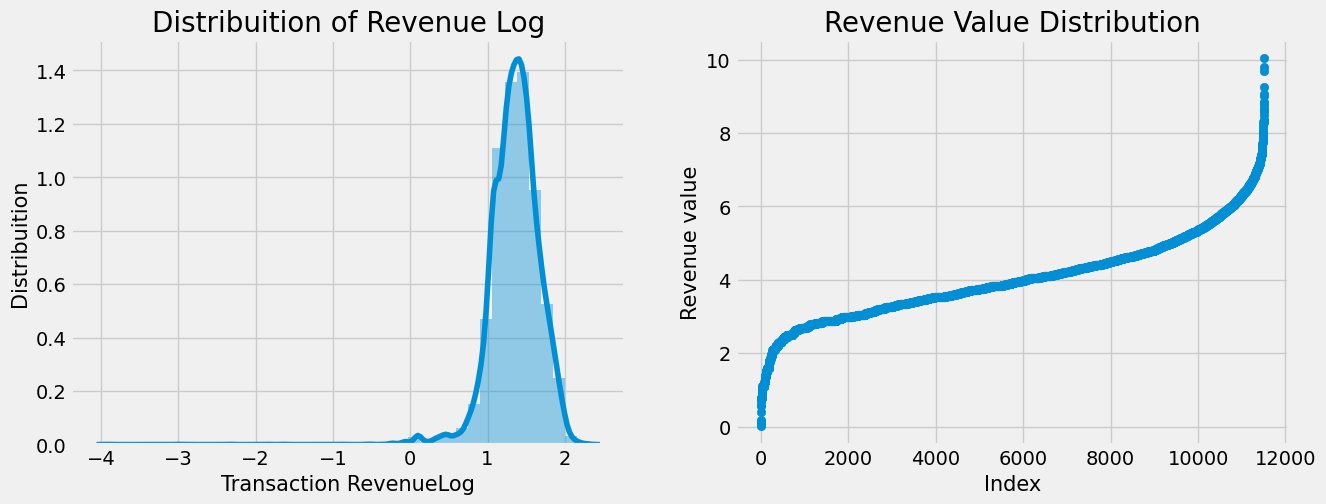

Excess kurtosis of normal distribution (should be 0): 0.7137049914922335
Skewness of normal distribution (should be 0): 0.5259458787198229


In [70]:
rev_log_distbn(df)

Our data are fairly symmetrical skewed and have a High Kurtosis.

I will see how many outliers we have on this dataset.

In [71]:
CalcOutliers(df['totals.transactionRevenue'])

Identified lowest outliers: 6
Identified upper outliers: 53
Identified outliers: 59
Non-outlier observations: 11456
Total percentual of Outliers:  0.515


In [72]:
CalcOutliers(df['totals.pageviews'])

Identified lowest outliers: 0
Identified upper outliers: 158
Identified outliers: 158
Non-outlier observations: 11357
Total percentual of Outliers:  1.3912


Percentual of Browser usage: 
Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Name: device.browser, dtype: int64


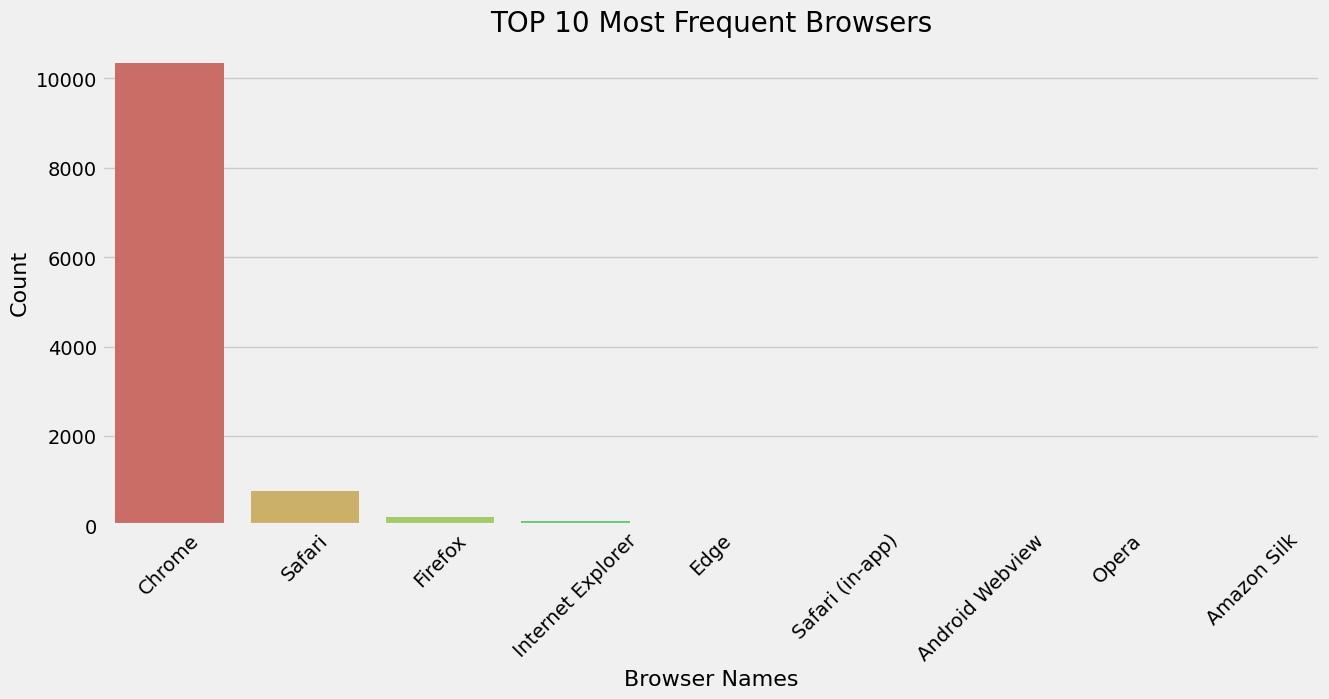

In [73]:
# the top 10 browsers represent % of total
print("Percentual of Browser usage: ")
print(df['device.browser'].value_counts()[:7])  # printing the top 7 percentage of browsers

# setting the graph size
plt.figure(figsize=(14, 6))

# Let's explore the browser used by users
top_browsers = df['device.browser'].value_counts()[:10].index
sns.countplot(data=df, x='device.browser', order=top_browsers, palette="hls")  # Use order parameter to display in a specific order
plt.title("TOP 10 Most Frequent Browsers", fontsize=20)
plt.xlabel("Browser Names", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(rotation=45)
plt.show()


Percentual of Channel Grouping used: 
Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Name: channelGrouping, dtype: int64


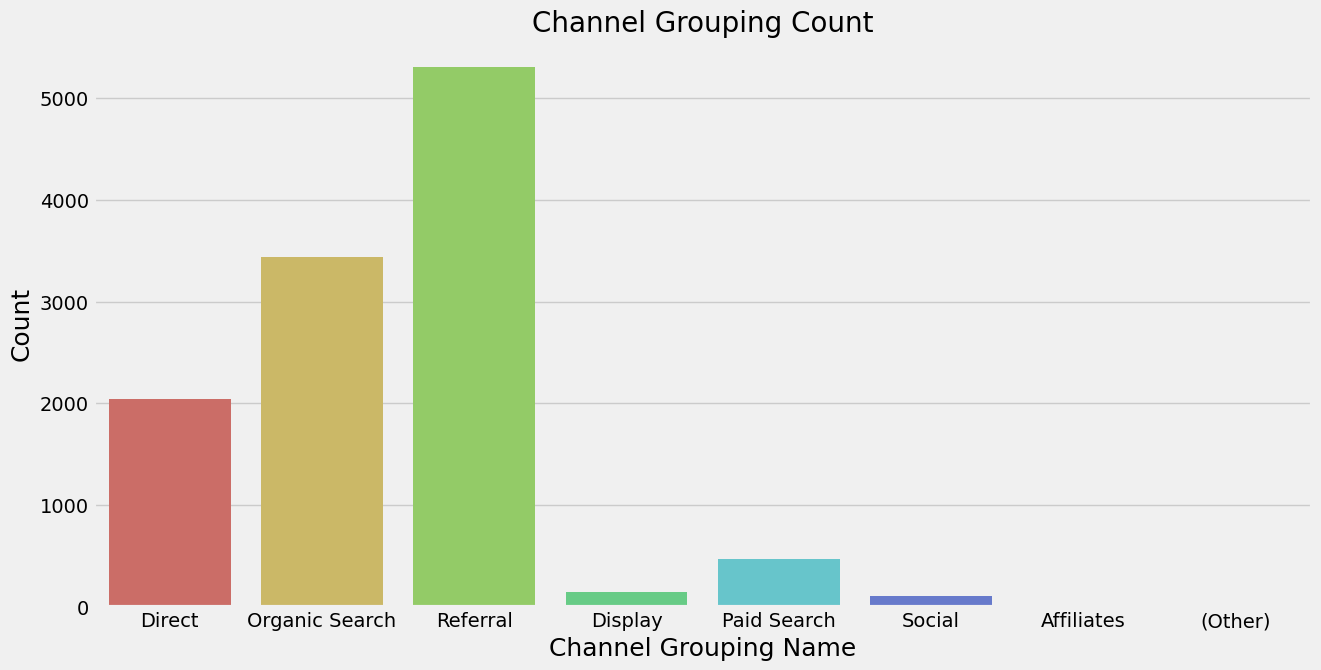

In [74]:
# the top 10 of browsers represent % of total
print("Percentual of Channel Grouping used: ")
print((df['channelGrouping'].value_counts()[:5])) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(data = df, x = "channelGrouping", palette="hls") # It's a module to count the category's
plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above

In [75]:
df['channelGrouping']

752               Direct
753       Organic Search
799             Referral
802             Referral
859             Referral
               ...      
903302          Referral
903305          Referral
903314          Referral
903315            Direct
903317            Direct
Name: channelGrouping, Length: 11515, dtype: object

In [76]:
df_causal = df.copy()

# new column, 'Referral' to indicate 1 if the traffic source is a referral, else 0 
df_causal['Referral'] = df_causal['channelGrouping'].apply(lambda x: 1 if x == 'Referral' else 0)


## Bi-variate Analysis of the features against the target

In [77]:
# set plot size
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# # plot a grid of beautiful scatter plots of all numerical variables against totals.transactionRevenue
# for i, col in enumerate(num_cols):
#     plt.subplot(3, 3, i+1)
#     plt.scatter(df[col], df['totals.transactionRevenue'])
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylabel('totals.transactionRevenue')
#     # make charts more spaced
#     plt.subplots_adjust(hspace=0.5)

<Figure size 2000x1000 with 0 Axes>

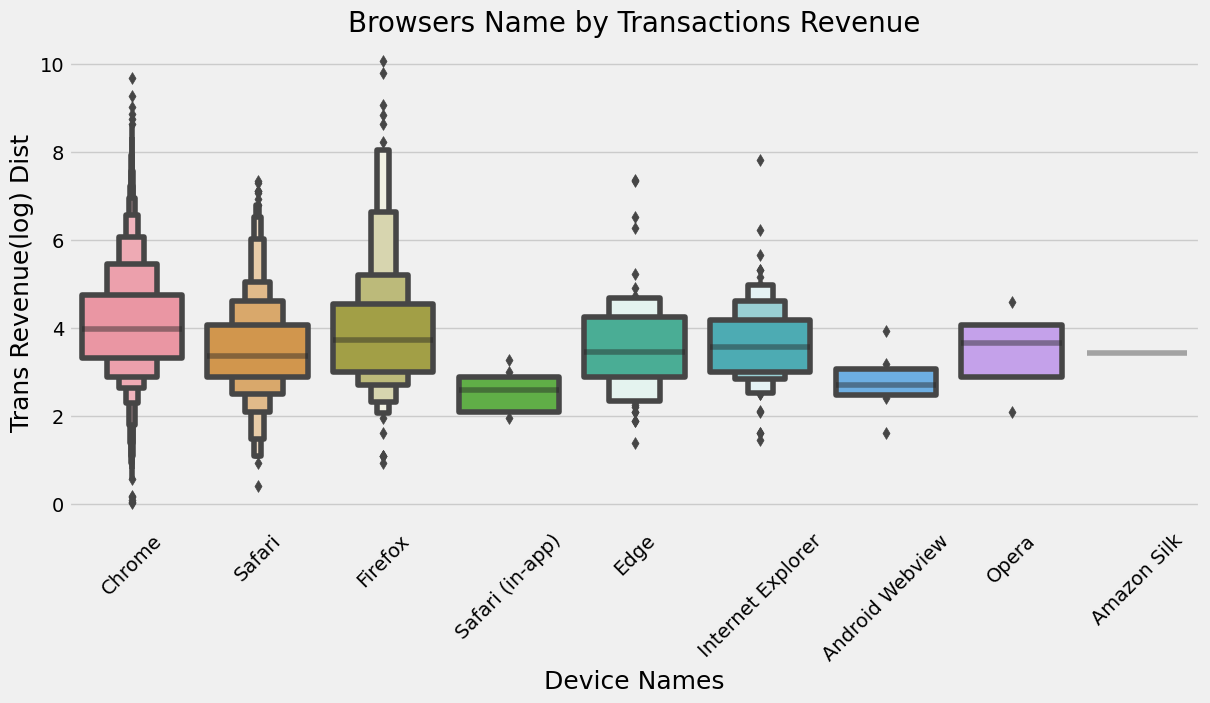

Percentual of Operational System: 
Macintosh    6426
Windows      2309
Chrome OS     994
Linux         782
iOS           536
Name: device.operatingSystem, dtype: int64


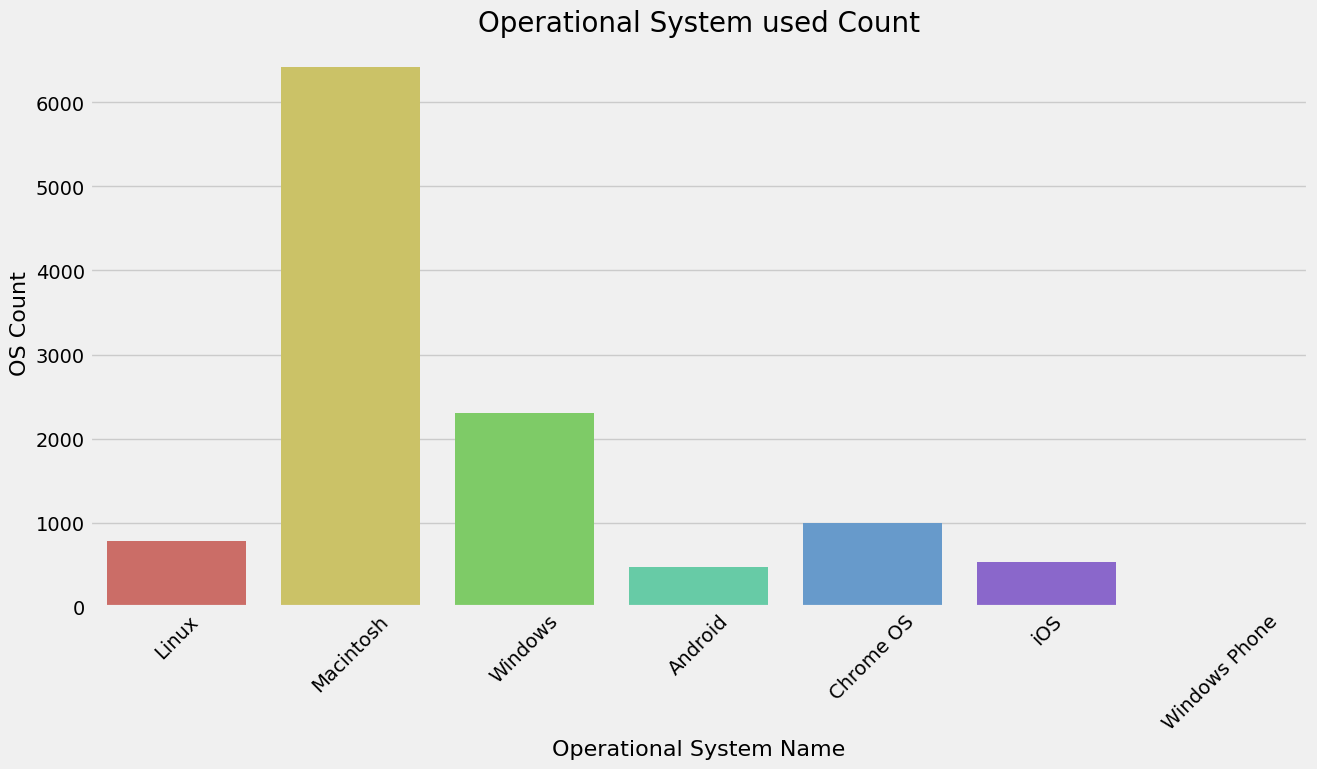

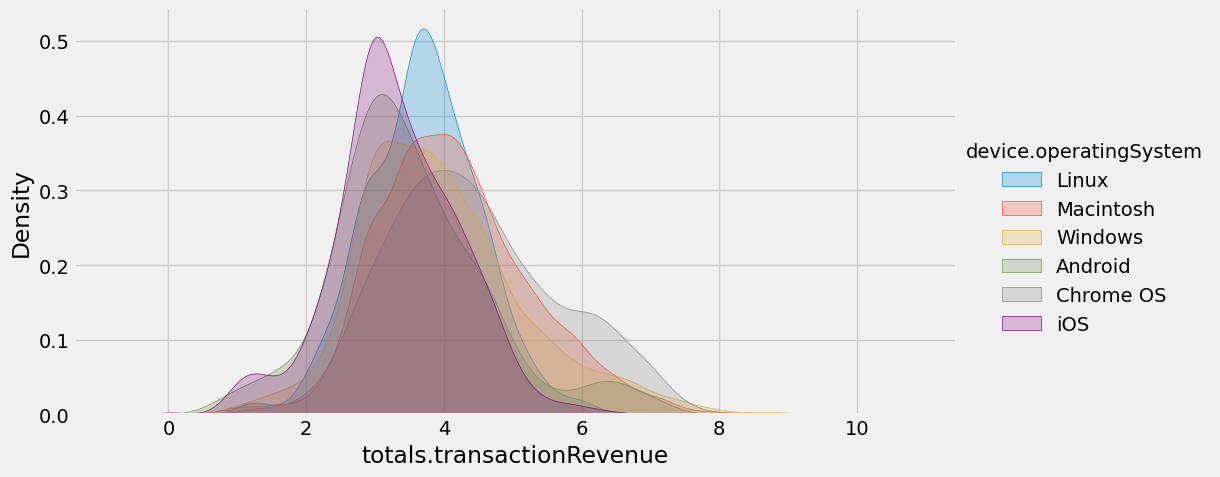

Percentual of Operational System: 
desktop   91
mobile     7
tablet     1
Name: device.deviceCategory, dtype: float64


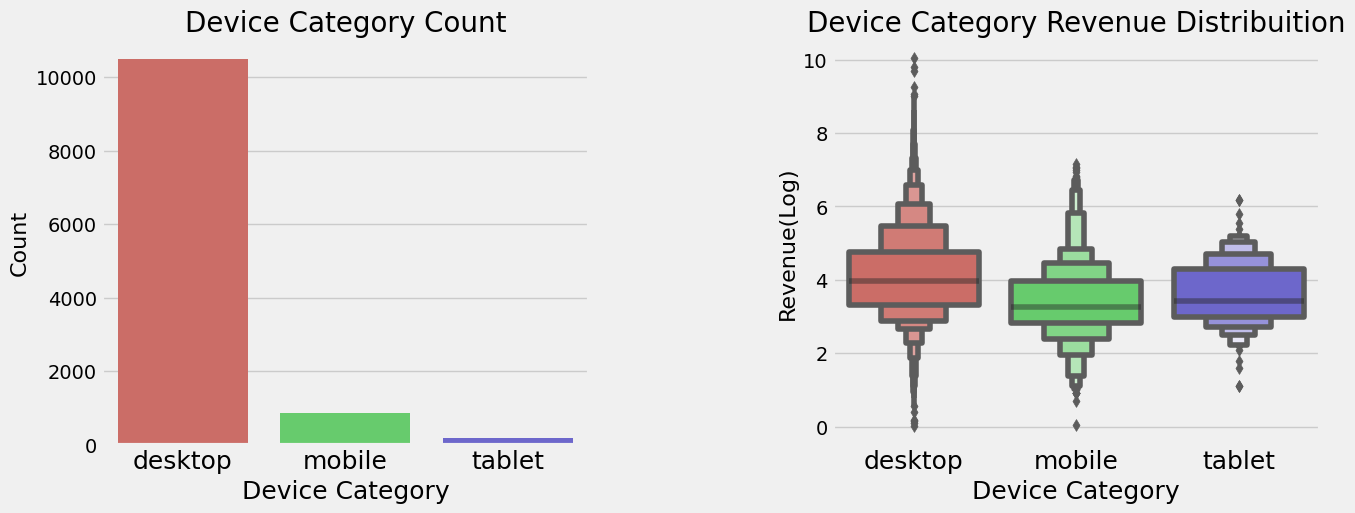

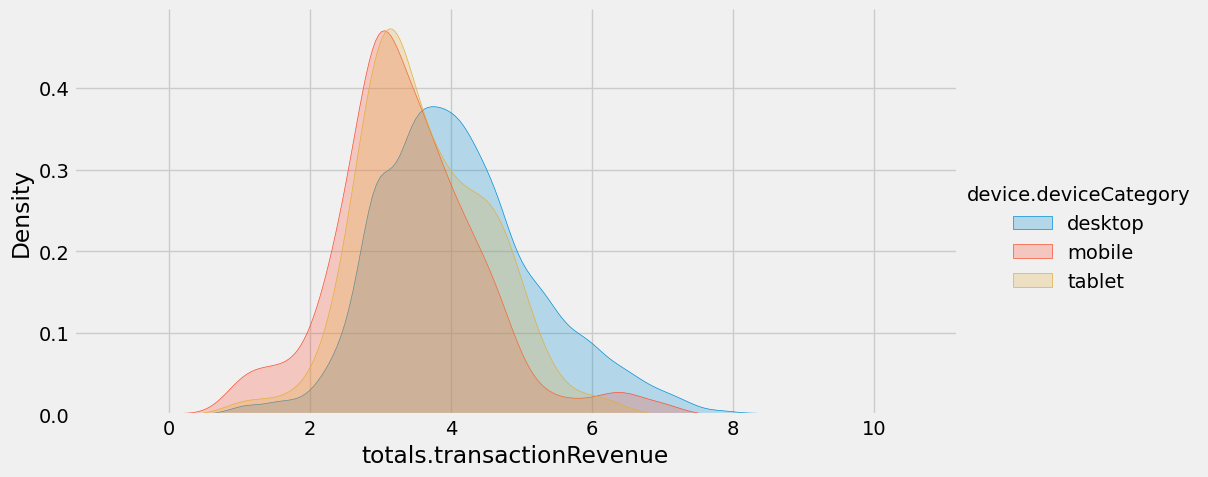

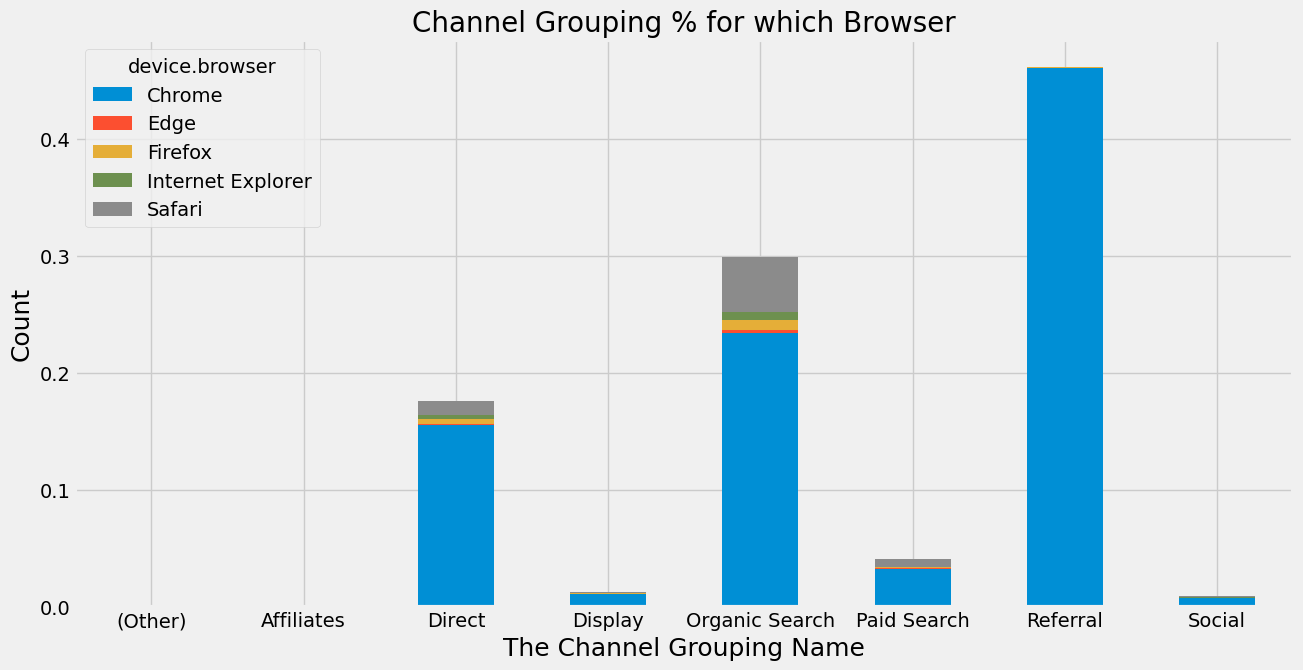

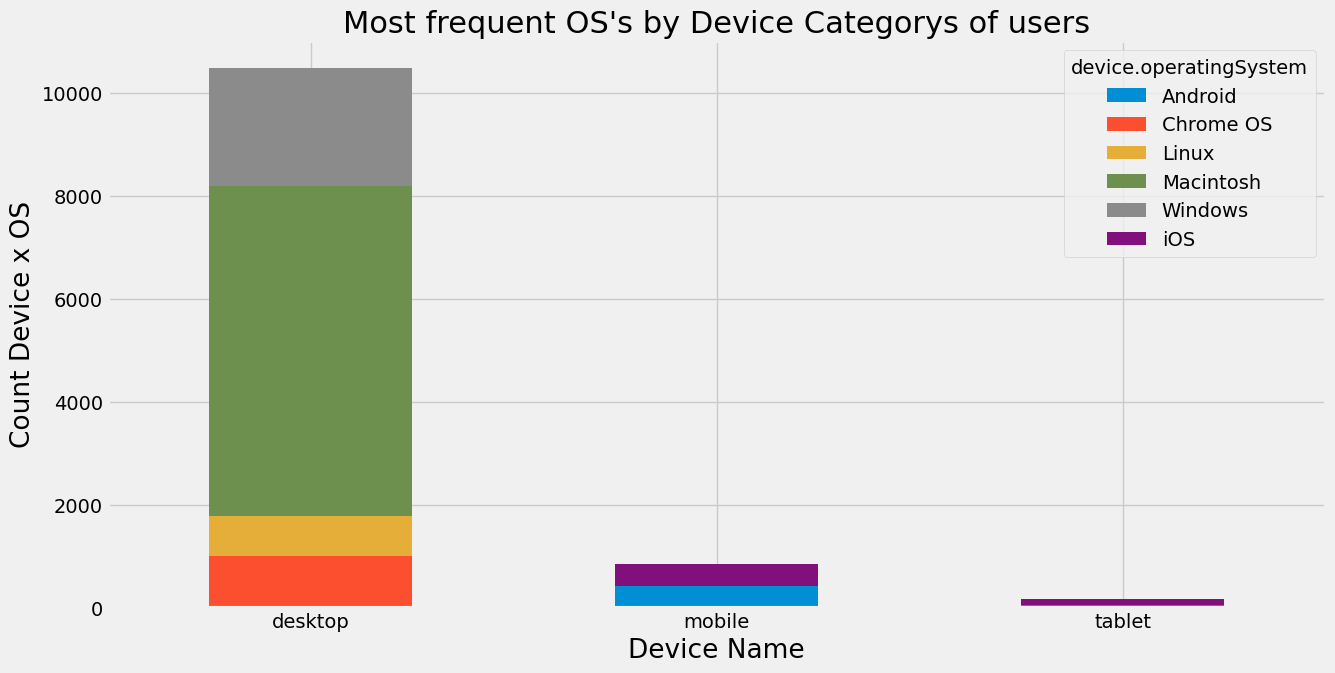

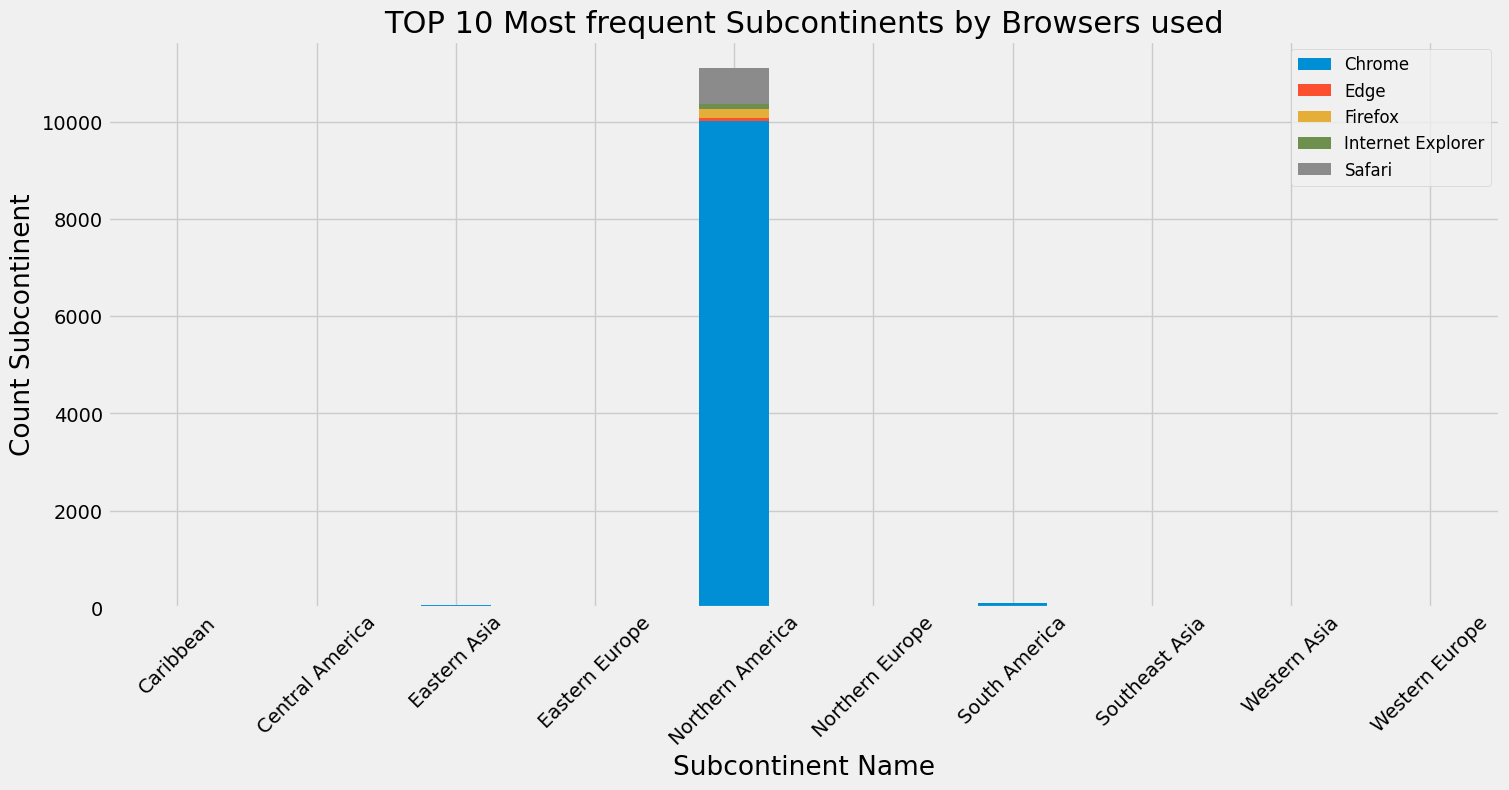

In [19]:
bivariate_analysis(df)

### Missing Information Visualization

In [20]:
# count missing values in each column
df.isnull().sum()

channelGrouping                              0
date                                         0
fullVisitorId                                0
sessionId                                    0
visitId                                      0
visitNumber                                  0
device.browser                               0
device.operatingSystem                       0
device.isMobile                              0
device.deviceCategory                        0
geoNetwork.continent                         0
geoNetwork.subContinent                      0
geoNetwork.country                           0
geoNetwork.region                            0
geoNetwork.metro                             0
geoNetwork.city                             49
geoNetwork.networkDomain                     0
totals.hits                                  0
totals.pageviews                             0
totals.newVisits                             0
totals.transactionRevenue                    0
trafficSource

### Extended EDA for Business

In [21]:
df = timerelated_fields(df)

In [22]:
# interactive_business_viz(df)

In [23]:
df

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
752,Direct,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,(not set),0,11,1,4,(direct),(none),True,True,4,2,9,2016,15
753,Organic Search,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),0,10,0,6,google,organic,True,True,4,2,9,2016,15
799,Referral,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),0,11,0,4,mall.googleplex.com,referral,True,True,4,2,9,2016,10
802,Referral,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),0,12,0,3,mall.googleplex.com,referral,True,True,4,2,9,2016,15
859,Referral,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),0,14,0,6,mall.googleplex.com,referral,True,True,4,2,9,2016,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,Referral,2017-01-04,6849604863010168468,6849604863010168468_1483566314,1483566314,10,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),0,48,0,6,mall.googleplex.com,referral,True,True,2,4,1,2017,16
903305,Referral,2017-01-04,0211986650009953276,0211986650009953276_1483568879,1483568879,2,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Texas,Austin TX,Austin,(not set),0,30,0,6,mall.googleplex.com,referral,True,True,2,4,1,2017,17
903314,Referral,2017-01-04,9981562221973608723,9981562221973608723_1483576938,1483576938,1,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,(not set),0,90,1,3,mall.googleplex.com,referral,False,True,2,4,1,2017,19
903315,Direct,2017-01-04,963126344221316701,963126344221316701_1483552674,1483552674,3,Firefox,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,optonline.net,0,90,0,4,(direct),(none),True,True,2,4,1,2017,12


### Type of data Analysis

Predictive Analysis - Prediction of Revenue Generation by customer

### Categorical Encodings (One hot and label)

In [24]:
# Encoder
encoded_result = encoders(df)
encoded_df = encoded_result[0]
encoding_mappings = encoded_result[1]
print("Encoded DataFrame:")
encoded_df
# print("\nEncoding Mappings:")
# encoding_mappings

Encoded DataFrame:


,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
752,2,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,2,2,0,0,2,9,66,40,12,2,0,0,11,1,4,0,0,1,1,4,2,9,2016,15
753,4,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,2,3,0,0,2,9,66,48,27,75,0,0,10,0,6,15,5,1,1,4,2,9,2016,15
799,6,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,2,2,0,0,2,9,66,48,27,75,0,0,11,0,4,25,6,1,1,4,2,9,2016,10
802,6,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,2,4,0,0,2,9,66,10,41,71,0,0,12,0,3,25,6,1,1,4,2,9,2016,15
859,6,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,2,3,0,0,2,9,66,78,45,132,0,0,14,0,6,25,6,1,1,4,2,9,2016,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,6,2017-01-04,6849604863010168468,6849604863010168468_1483566314,1483566314,10,2,3,0,0,2,9,66,48,27,75,0,0,48,0,6,25,6,1,1,2,4,1,2017,16
903305,6,2017-01-04,0211986650009953276,0211986650009953276_1483568879,1483568879,2,2,3,0,0,2,9,66,68,2,6,0,0,30,0,6,25,6,1,1,2,4,1,2017,17
903314,6,2017-01-04,9981562221973608723,9981562221973608723_1483576938,1483576938,1,2,3,0,0,3,6,55,59,0,112,0,0,90,1,3,25,6,0,1,2,4,1,2017,19
903315,2,2017-01-04,963126344221316701,963126344221316701_1483552674,1483552674,3,4,3,0,0,2,9,66,48,27,75,449,0,90,0,4,0,0,1,1,2,4,1,2017,12


In [25]:
# decoded_df = decoders(encoded_df, encoding_mappings)
# df

### Predictors and Target

In [26]:
X = df.drop(['totals.transactionRevenue', 'fullVisitorId', 'sessionId', 'visitId', 'date' ], axis=1)
Y = df['totals.transactionRevenue']

In [27]:
X 

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
752,2,1,2,2,0,0,2,9,66,40,12,2,0,0,11,1,0,0,1,1,4,2,9,2016,15
753,4,3,2,3,0,0,2,9,66,48,27,75,0,0,10,0,15,5,1,1,4,2,9,2016,15
799,6,7,2,2,0,0,2,9,66,48,27,75,0,0,11,0,25,6,1,1,4,2,9,2016,10
802,6,6,2,4,0,0,2,9,66,10,41,71,0,0,12,0,25,6,1,1,4,2,9,2016,15
859,6,4,2,3,0,0,2,9,66,78,45,132,0,0,14,0,25,6,1,1,4,2,9,2016,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,6,10,2,3,0,0,2,9,66,48,27,75,0,0,48,0,25,6,1,1,2,4,1,2017,16
903305,6,2,2,3,0,0,2,9,66,68,2,6,0,0,30,0,25,6,1,1,2,4,1,2017,17
903314,6,1,2,3,0,0,3,6,55,59,0,112,0,0,90,1,25,6,0,1,2,4,1,2017,19
903315,2,3,4,3,0,0,2,9,66,48,27,75,449,0,90,0,0,0,1,1,2,4,1,2017,12


### Correlation Matrix

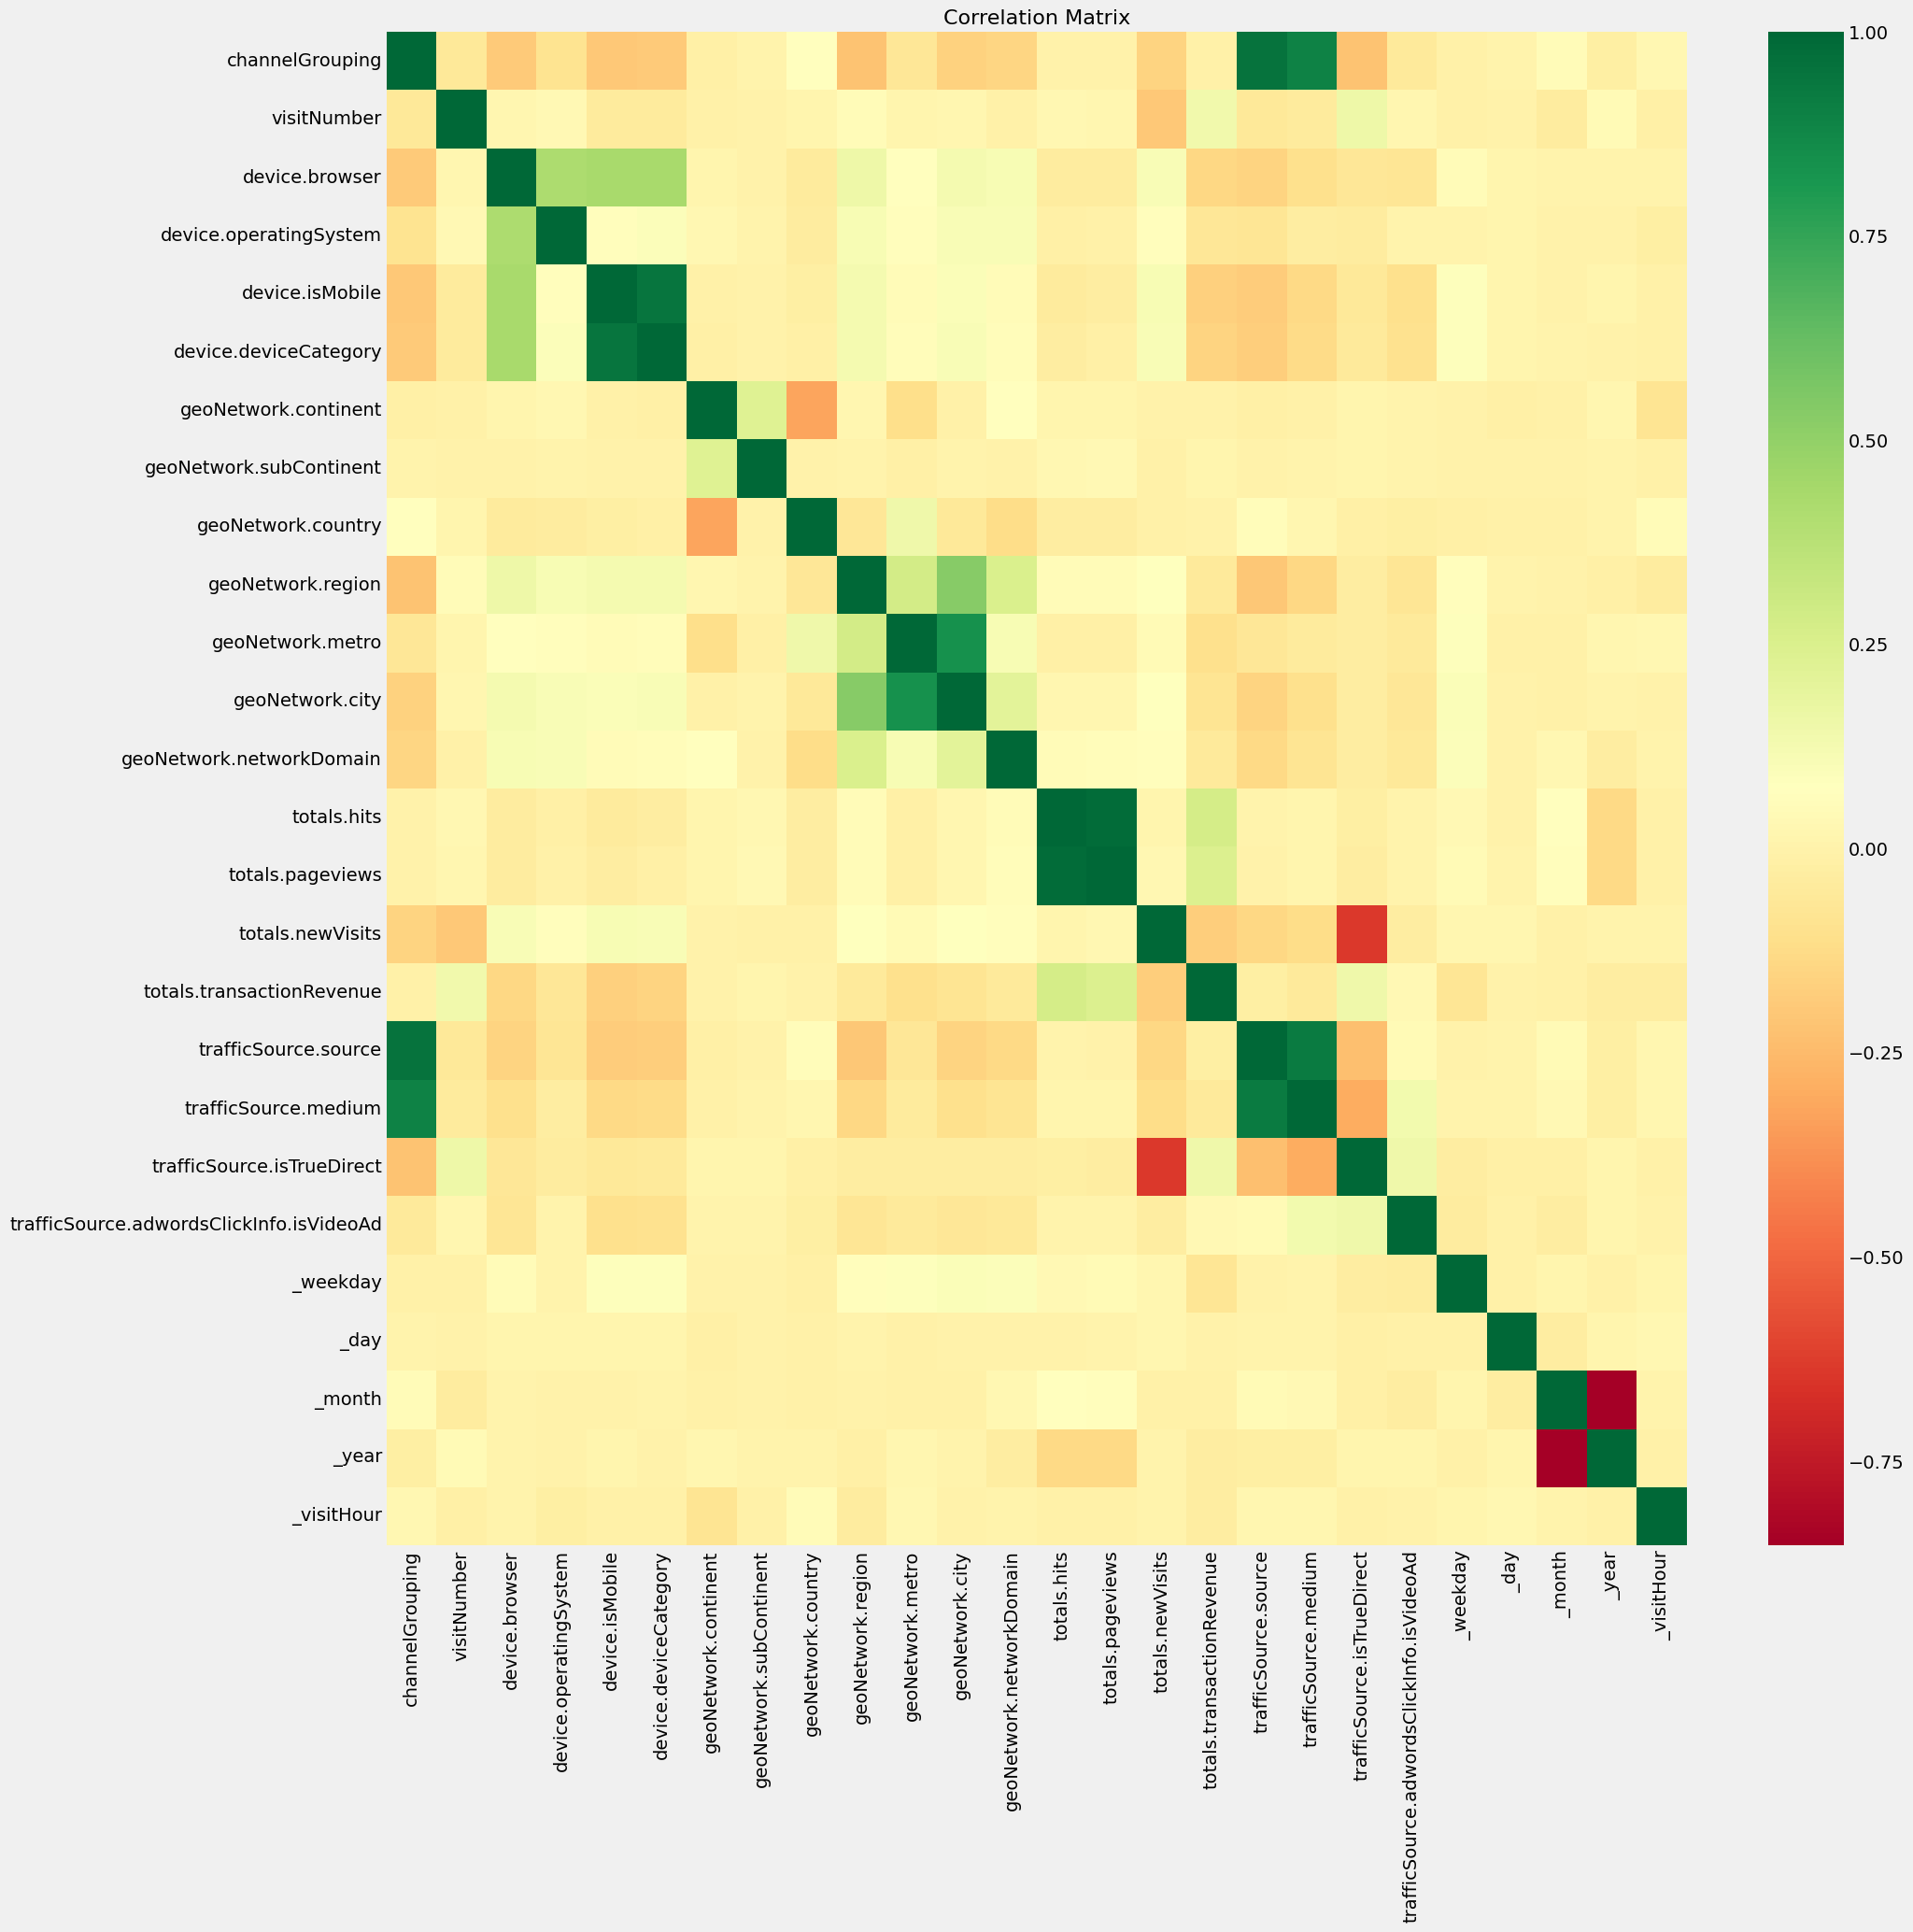

In [28]:
# correlation matrix seaborn
pp = df.drop(['visitId', 'fullVisitorId', 'sessionId', 'date' ], axis=1)
plt.figure(figsize=(20, 20))
sns.heatmap(pp.corr(), annot=False, cmap="RdYlGn")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

# Section 3 - Prediction Model

### Train Test Split

In [29]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

### Handling Imbalanced Datasets

In [30]:


# # add a column 'non_zero_revenue' to train_df with value 1 if totals.transactionRevenue is non-zero and 0 otherwise
# df['non_zero_revenue'] = np.where(df['totals.transactionRevenue'] > 0, 1, 0)

# from smogn import smoter
# # Oversample df using smoter
# train_df_oversampled = smoter(data=df, y='totals.transactionRevenue')



In [31]:
print(df['totals.transactionRevenue'].value_counts())

3    256
3    189
4    187
4    170
3    135
    ... 
6      1
5      1
5      1
4      1
4      1
Name: totals.transactionRevenue, Length: 5332, dtype: int64


### Over under ssampling or other hybrid approaches such as smotetomek and smotheen 

In [32]:
# oversampling non zero revenue rows

# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, Y)



### Sota Modeling (XGBoost, LGBM, Catboost, Deep learnign architectures, stacking)

In [33]:
## 6min to run on m2 chip
# light gbm

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state":42,
        'max_depth': 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train, lgb_eval])  # You can provide a list of datasets for validation)

# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importance()))


The rmse of prediction is: 1.0553670046738715
Feature importances: [2584, 12817, 1462, 3533, 357, 367, 572, 1143, 2950, 4362, 3863, 6612, 12352, 20630, 17955, 118, 3902, 1092, 1015, 104, 7086, 14576, 10030, 843, 11437]


### LightGBM, XGBoost, Catboost Stacked

In [34]:
## run time 8 mins on m2 chip

def lightGBM_XGB_CatBoost_Stacked_Model(X_train, X_test, y_train, y_test):
    # Split the data for training and validation
    X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # LightGBM
    lgb_train = lgb.Dataset(X_train_stack, y_train_stack)
    lgb_eval = lgb.Dataset(X_val_stack, y_val_stack, reference=lgb_train)

    # Note - hyperparameters are directly added to avoid long processing time for hyperparameter tuning
    lgb_params = {
        'learning_rate': 0.01,
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state": 42,
        'max_depth': 5,
        "bagging_seed": 42,
        "verbosity": -1,
        "bagging_frequency": 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
    }

    lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_eval])

    # XGBoost
    xgb_train = xgb.DMatrix(X_train_stack, label=y_train_stack)
    xgb_val = xgb.DMatrix(X_val_stack, label=y_val_stack)

    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma': 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

    xgb_model = xgb.train(xgb_params, xgb_train, num_boost_round=2000, evals=[(xgb_train, 'train'), (xgb_val, 'eval')])

    # CatBoost
    cat_model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.03,
        depth=10,
        eval_metric='RMSE',
        od_type='Iter',
        metric_period=50,
        od_wait=20,
        random_seed=42
    )

    cat_model.fit(X_train_stack, y_train_stack, eval_set=(X_val_stack, y_val_stack))

    # Combine predictions
    lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    xgb_pred = xgb_model.predict(xgb.DMatrix(X_test))
    cat_pred = cat_model.predict(X_test)

    # Simple averaging of predictions
    stacked_pred = (lgb_pred + xgb_pred + cat_pred) / 3

    # Evaluate stacked model
    stacked_rmse = mean_squared_error(y_test, stacked_pred) ** 0.5
    print('The RMSE of the stacked model is:', stacked_rmse)

    return stacked_pred

lightGBM_XGB_CatBoost_Stacked_Model(X_train, X_test, y_train, y_test)


[0]	train-rmse:1.15455	eval-rmse:1.17865
[1]	train-rmse:1.15453	eval-rmse:1.17862
[2]	train-rmse:1.15399	eval-rmse:1.17815
[3]	train-rmse:1.15398	eval-rmse:1.17815
[4]	train-rmse:1.15324	eval-rmse:1.17724
[5]	train-rmse:1.15273	eval-rmse:1.17678
[6]	train-rmse:1.15256	eval-rmse:1.17665
[7]	train-rmse:1.15211	eval-rmse:1.17624
[8]	train-rmse:1.15003	eval-rmse:1.17452
[9]	train-rmse:1.14941	eval-rmse:1.17390
[10]	train-rmse:1.14940	eval-rmse:1.17389
[11]	train-rmse:1.14926	eval-rmse:1.17374
[12]	train-rmse:1.14923	eval-rmse:1.17374
[13]	train-rmse:1.14875	eval-rmse:1.17331
[14]	train-rmse:1.14823	eval-rmse:1.17285
[15]	train-rmse:1.14757	eval-rmse:1.17203
[16]	train-rmse:1.14653	eval-rmse:1.17114
[17]	train-rmse:1.14650	eval-rmse:1.17113
[18]	train-rmse:1.14635	eval-rmse:1.17099
[19]	train-rmse:1.14620	eval-rmse:1.17083
[20]	train-rmse:1.14553	eval-rmse:1.16999
[21]	train-rmse:1.14552	eval-rmse:1.16999
[22]	train-rmse:1.14511	eval-rmse:1.16962
[23]	train-rmse:1.14464	eval-rmse:1.16921
[2

50:	learn: 0.9890373	test: 1.0746847	best: 1.0746847 (50)	total: 410ms	remaining: 3.61s
100:	learn: 0.9326778	test: 1.0560784	best: 1.0560784 (100)	total: 732ms	remaining: 2.89s
150:	learn: 0.9002761	test: 1.0512803	best: 1.0512803 (150)	total: 1.05s	remaining: 2.43s
200:	learn: 0.8743952	test: 1.0476592	best: 1.0475921 (199)	total: 1.46s	remaining: 2.17s
250:	learn: 0.8523488	test: 1.0460651	best: 1.0460571 (242)	total: 1.82s	remaining: 1.81s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.0459716
bestIteration = 253

Shrink model to first 254 iterations.
The RMSE of the stacked model is: 1.0230412601593308


array([4.5659458 , 4.64052455, 2.98088896, ..., 3.58004628, 3.22771793,
       3.61246514])

### Model Evaluations to avoid overfitting and bias )ROC-AUC, .....RMSE, MAE, SR^25

RMSE:  1.0553670046738715
MAE:  0.8224546157660139


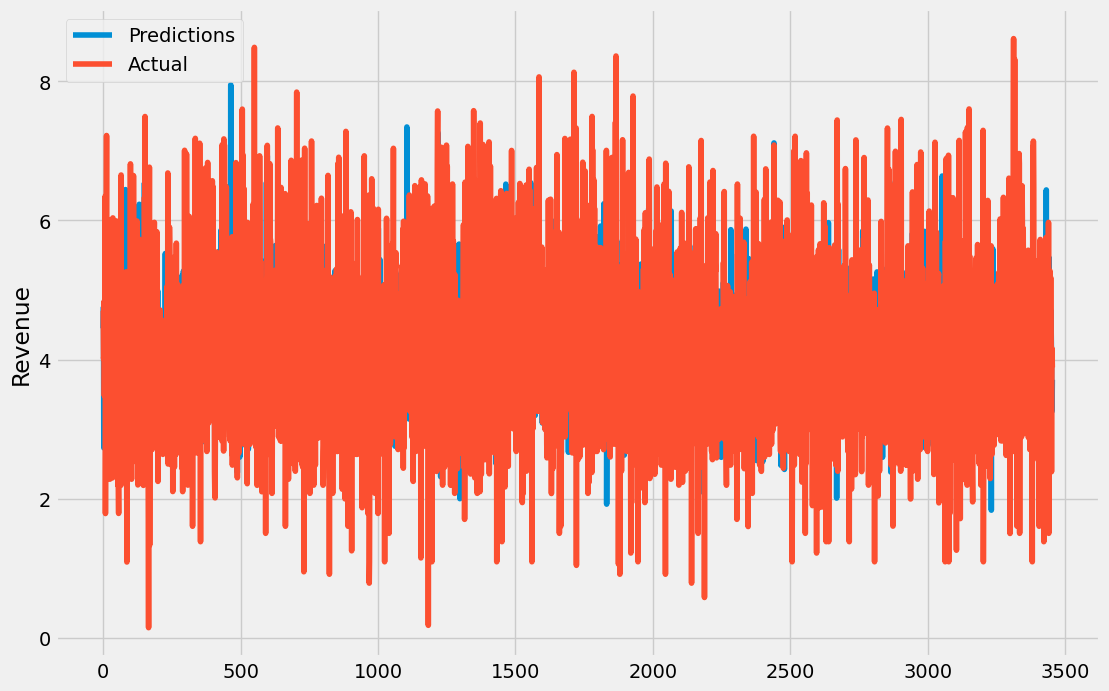

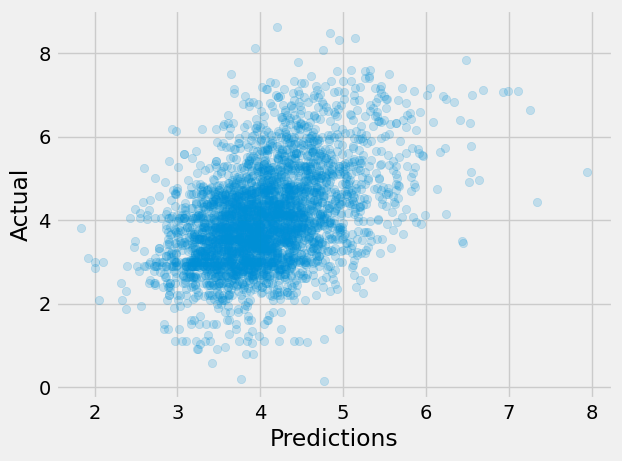

In [35]:
# model evaluations
# RMSE, MAE, R2, RMSLE, SR^25
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print("RMSE: ", RMSE)
print("MAE: ", MAE)


y_pred[y_pred < 0] = 0
# plot predictions and actual values
plt.figure(figsize=(12,8))
plt.plot(y_pred, label='Predictions')
plt.plot(y_test.values, label='Actual')
plt.ylabel('Revenue')
plt.legend()
plt.show()
# make color transparent
plt.scatter(y_pred, y_test, alpha=0.2)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.show()

### Explainability with SHAP or LIME

In [36]:
## this part has been moved to causal section


# # explainability with SHAP
# explainer = shap.TreeExplainer(gbm)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

### Hyper parameter optmization with hyper opt/optuna

In [37]:
# already done in model and commented out to save processing time as it took 7 hours to complete

### Model Persistence

In [38]:
import joblib

joblib.dump(lightGBM_XGB_CatBoost_Stacked_Model, "revenue_prediction_google_analytics.pkl")

['revenue_prediction_google_analytics.pkl']

### Model By Pipeline (uncomment to run)

Same code as above summarized in form of a pipeline

In [39]:

# gaData = pd.read_csv('train_v2.csv', dtype=dtypes, nrows=None)


# transform_pipeline = Pipeline(steps=[
#     ('clean_datatypes', FunctionTransformer(clean_datatypes)),
#     ('fix_nulls', FunctionTransformer(Fixing_Blanks_Nulls)),
#     ('remove_redundant', FunctionTransformer(removing_redundant_columns)),
#     ('normalize', FunctionTransformer(Normalizing)),
#     ('time_related', FunctionTransformer(timerelated_fields)),
#     ('encoders', FunctionTransformer(encoders)),
#     ('remove_columns_not_affecting_prediction', FunctionTransformer(remove_columns_not_affecting_prediction))
# ])

# df_transformed = transform_pipeline.transform(gaData)

# X = df_transformed.drop(['totals.transactionRevenue'], axis=1)
# Y = df_transformed['totals.transactionRevenue']
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

# lightGBM_XGB_CatBoost_Stacked_Model(X_train, X_test, y_train, y_test)f

# Section 4 - Causal Inference

The goal of this section was to apply as many causal inference techniques as possible from what we learned in class. 

First of all we will see the feature importances of the prediction model built in predictive model before

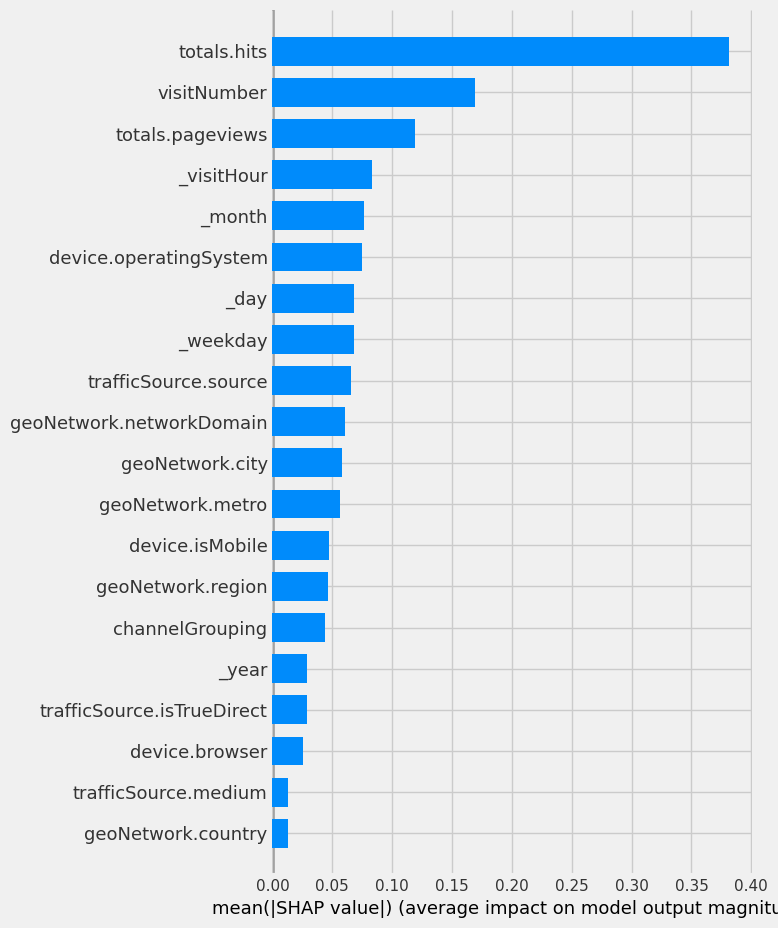

In [40]:
# explainability with SHAP
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### To study and analyse the hypotheses, the dataset taken is same as the prediction model with some modifications in preprocessing and feature engineering.

In [78]:
# copy of decoded df so we dont have to run the code above again if we need to debug part below this
Temp = df_causal

Text(0.5, 1.0, 'Distribution of Revenue')

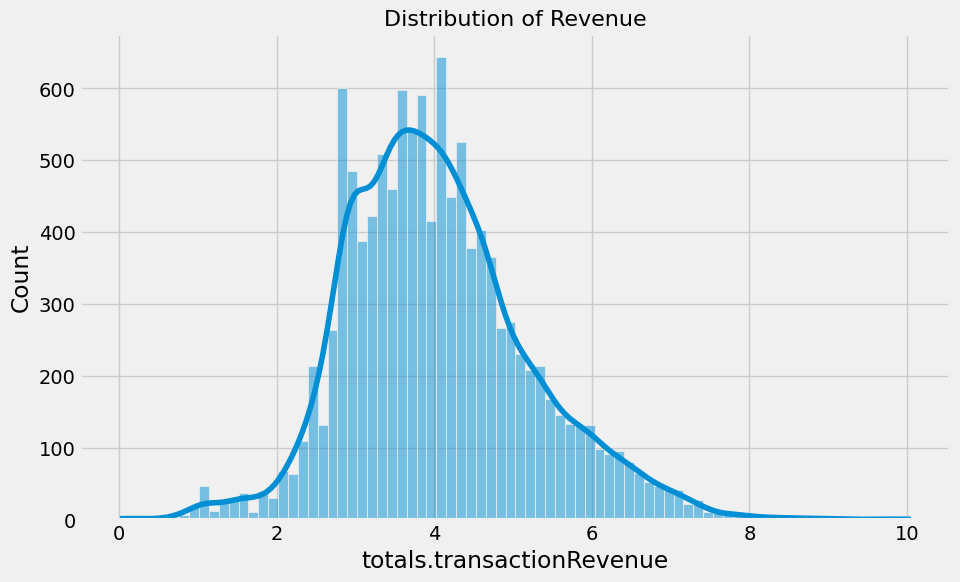

In [79]:
df_causal = Temp
df_casual = encoders(df_causal)

df_causal = df_causal.drop('channelGrouping', axis=1)

# revenue distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_causal['totals.transactionRevenue'], kde=True)

# add title
plt.title('Distribution of Revenue', fontsize=16)

# 3.1. A Tail of Referral's impact on Revenue Using Econ ML 

The hypothesis being tested here relates to the causal effect of the observational treatment variable T (in this case, device.browser) on the target variable y (in this case, totals.transactionRevenue), while controlling for the effects of other features represented by X.

In causal inference and econometrics, such analyses aim to understand the causal relationship between a treatment and an outcome variable. In this scenario, the hypothesis might be framed as:

Null Hypothesis (H0): There is no causal effect of the browser used (device.browser) on the revenue generated (totals.transactionRevenue) after controlling for other factors (X).

Alternative Hypothesis (H1): There exists a causal effect of the browser used (device.browser) on the revenue generated (totals.transactionRevenue) after controlling for other factors (X).

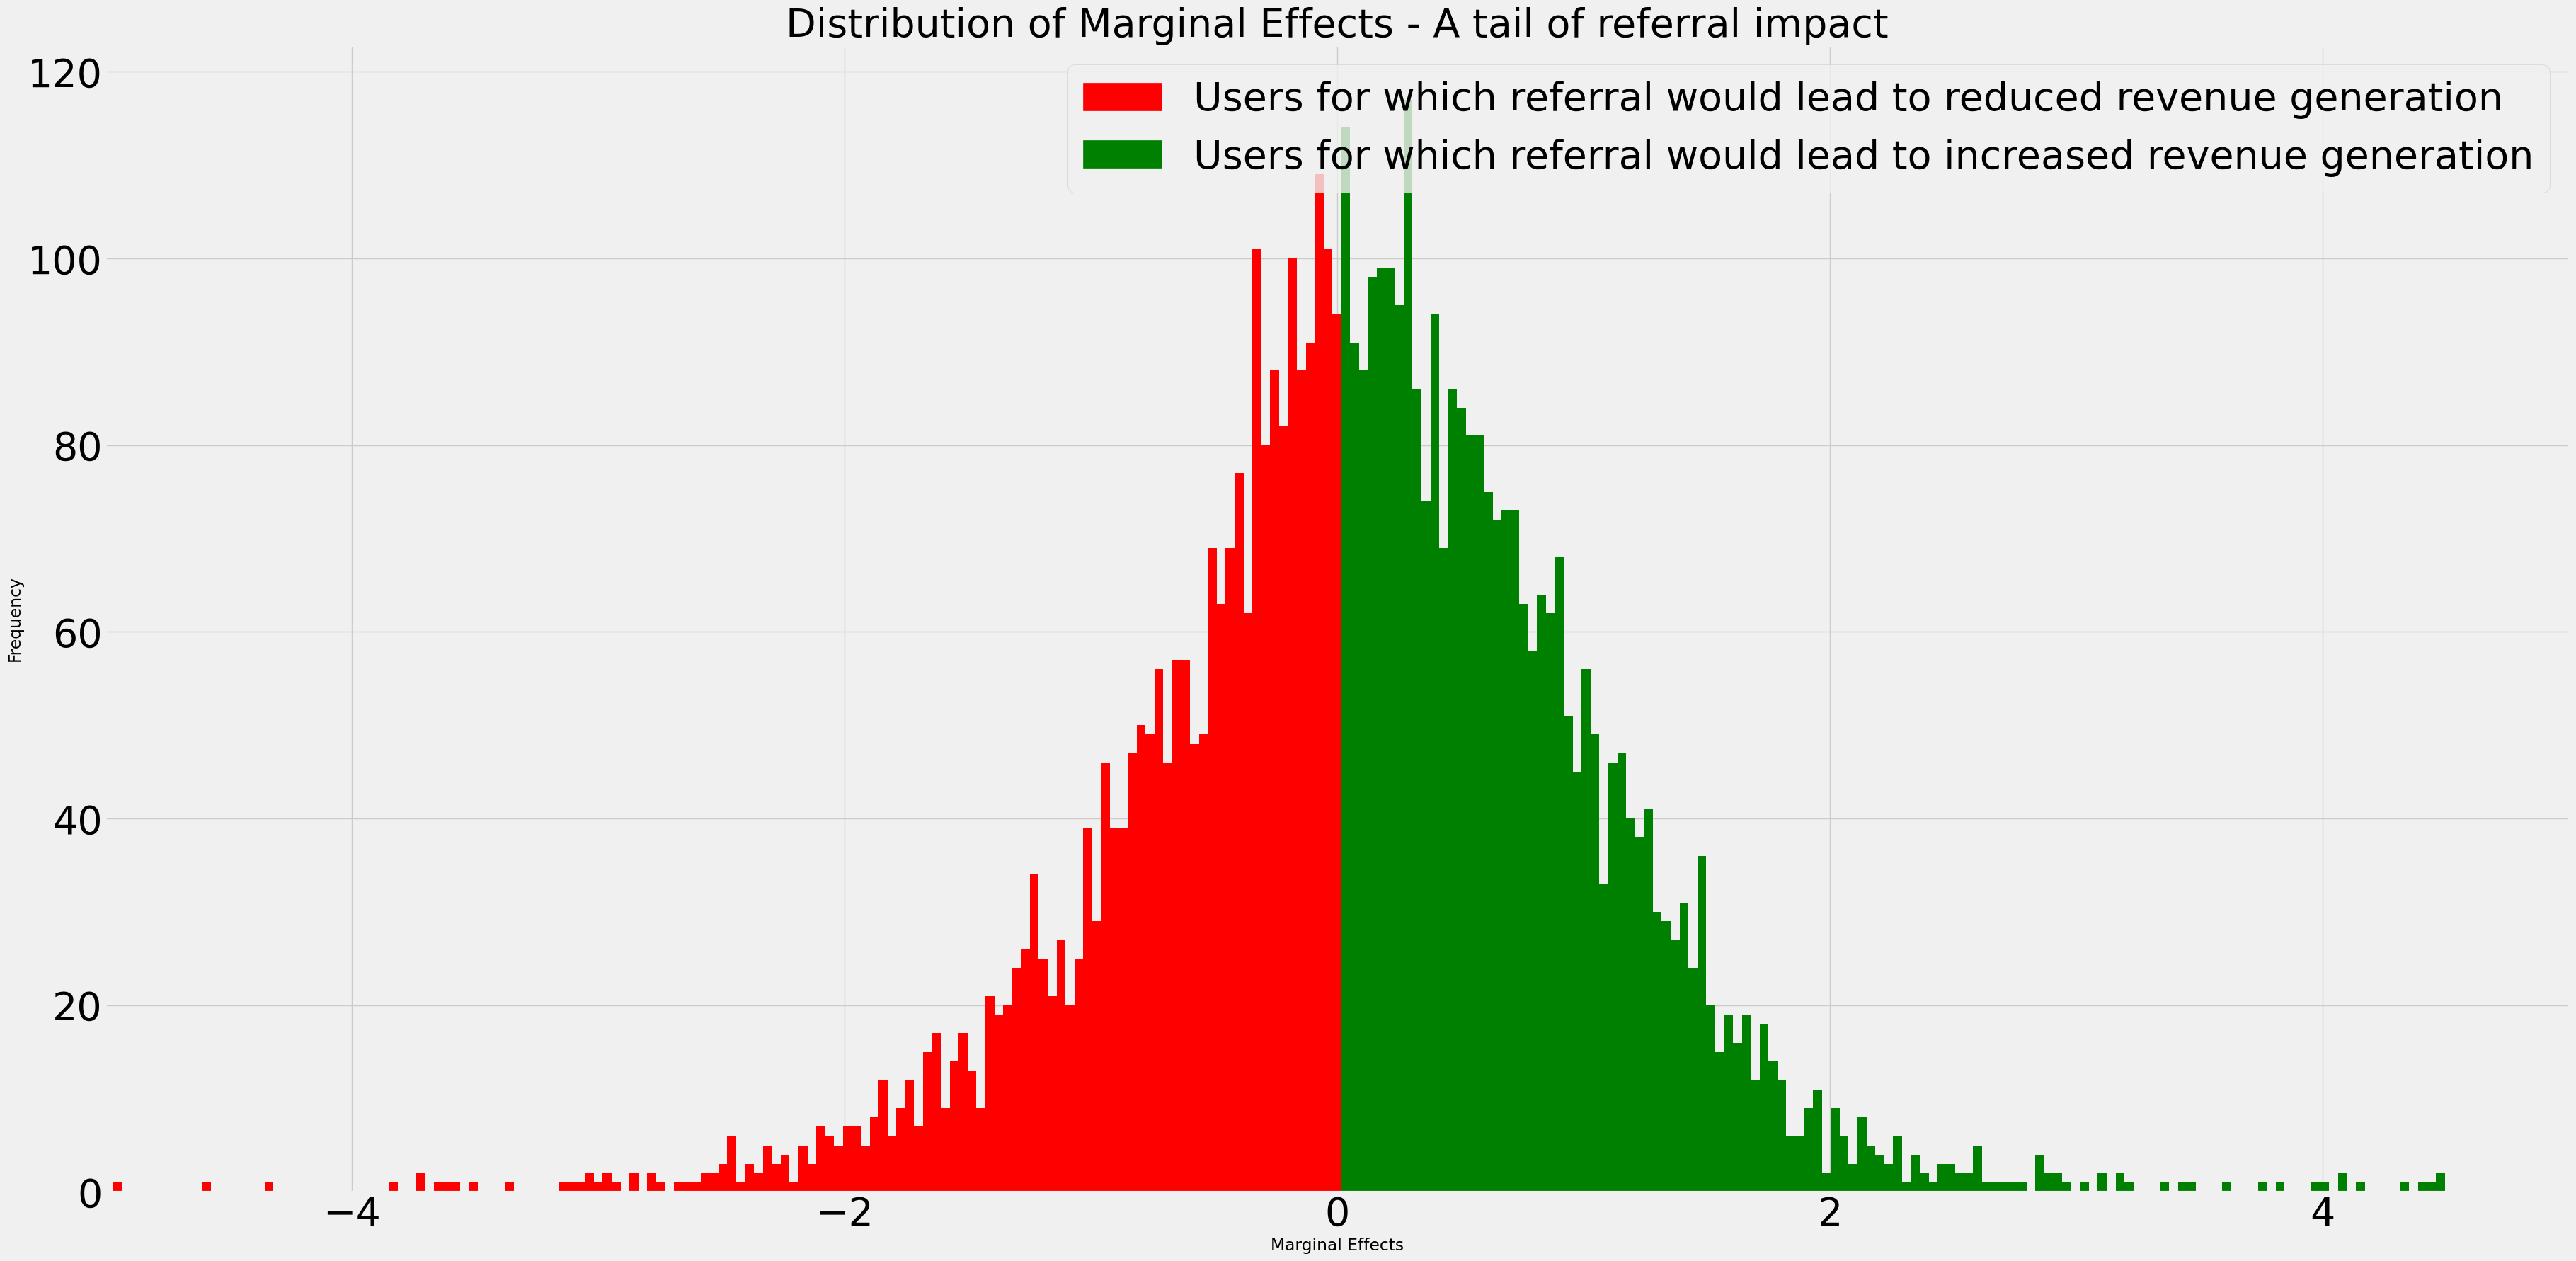

In [86]:
from econml.dml import LinearDML

# Assuming df is your DataFrame containing the necessary columns

# Extracting the target variable
y = df_causal['totals.transactionRevenue']

# Extracting the treatment variable
T = df_causal['Referral']

# Extracting the features
X = df_causal.drop(['totals.transactionRevenue', 'fullVisitorId', 'sessionId', 'visitId', 'date', 'Referral'], axis=1)

# Ensure X, y, and T are in the correct format
# X should be a numpy array or pandas DataFrame, y and T should be numpy arrays
X = X.values
y = y.values
T = T.values

# Initialize the LinearDML model
est = LinearDML()

# Fit the model
est.fit(y, T, X=X)

# Calculate constant marginal effect
marginal_effect = est.const_marginal_effect(X)
#add marginal_effect to df_causal_encoded
df_causal['marginal_effect'] = marginal_effect

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

marginal_effect_df = pd.DataFrame(marginal_effect)

# Assuming marginal_effect_df contains the marginal effects
marginal_effects = marginal_effect_df.values.flatten()

# color the bins based on the magnitude of x values 
# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(40, 20))

# Define the number of bins
num_bins = 10000

# Create histogram with specified bins and without plotting
n, bins, _ = ax.hist(marginal_effects, bins=num_bins)

# Add labels and title
ax.set_xlabel('Marginal Effects')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Marginal Effects')

# Set x-axis limits
ax.set_xlim(bins[0], bins[-1])

# Set the color of the bins based on the magnitude of the x values
for i in range(num_bins):
    if bins[i] < 0.:
        ax.patches[i].set_facecolor('r')
    elif bins[i] > 0:
        ax.patches[i].set_facecolor('g')
    else:
        ax.patches[i].set_facecolor('y')

# make font bigger
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

# color legend
red_patch = mpatches.Patch(color='red', label='Users for which referral would lead to reduced revenue generation')
green_patch = mpatches.Patch(color='green', label='Users for which referral would lead to increased revenue generation')

# add legend
plt.legend(handles=[red_patch, green_patch], fontsize=40)

# x range
plt.xlim(-5,5)


# title font bigger
plt.title('Distribution of Marginal Effects - A tail of referral impact', fontsize=40)



# Show the plot
plt.show()


### We can clearly see, for no referral instances the marginal effect is remarkably different

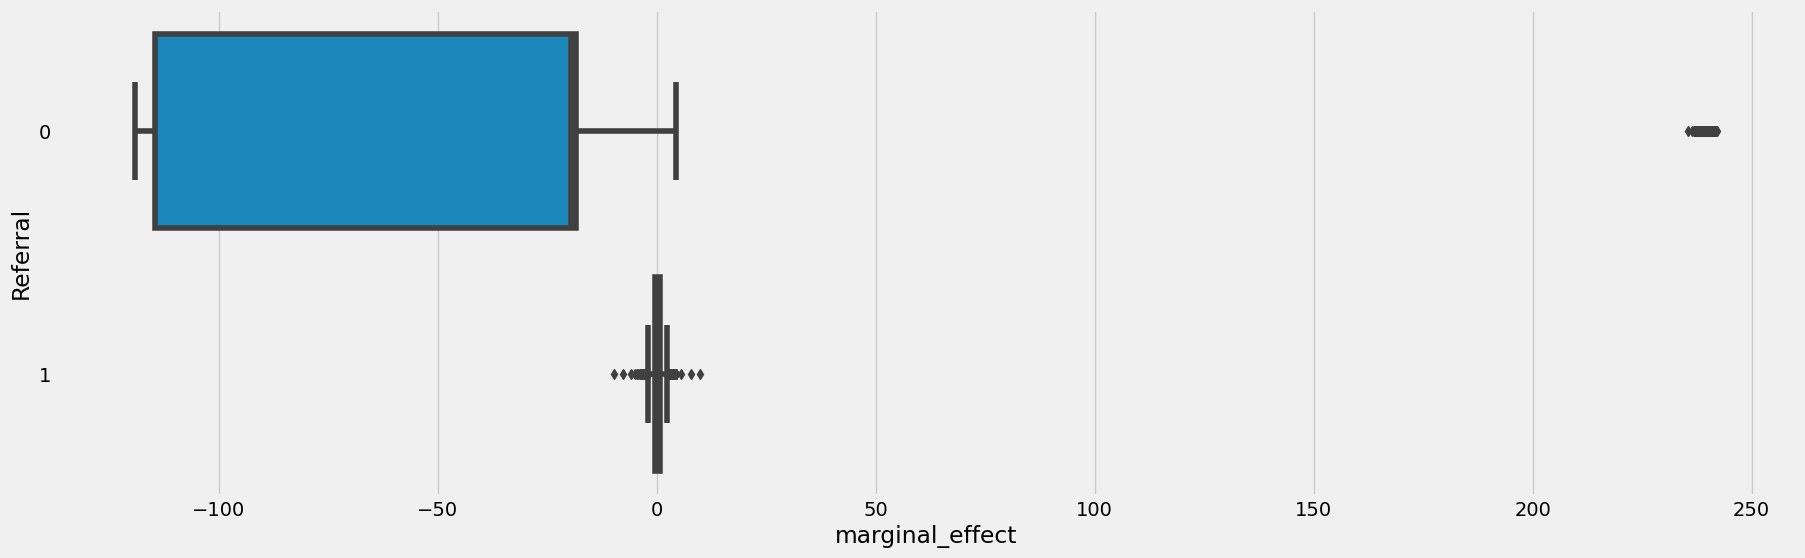

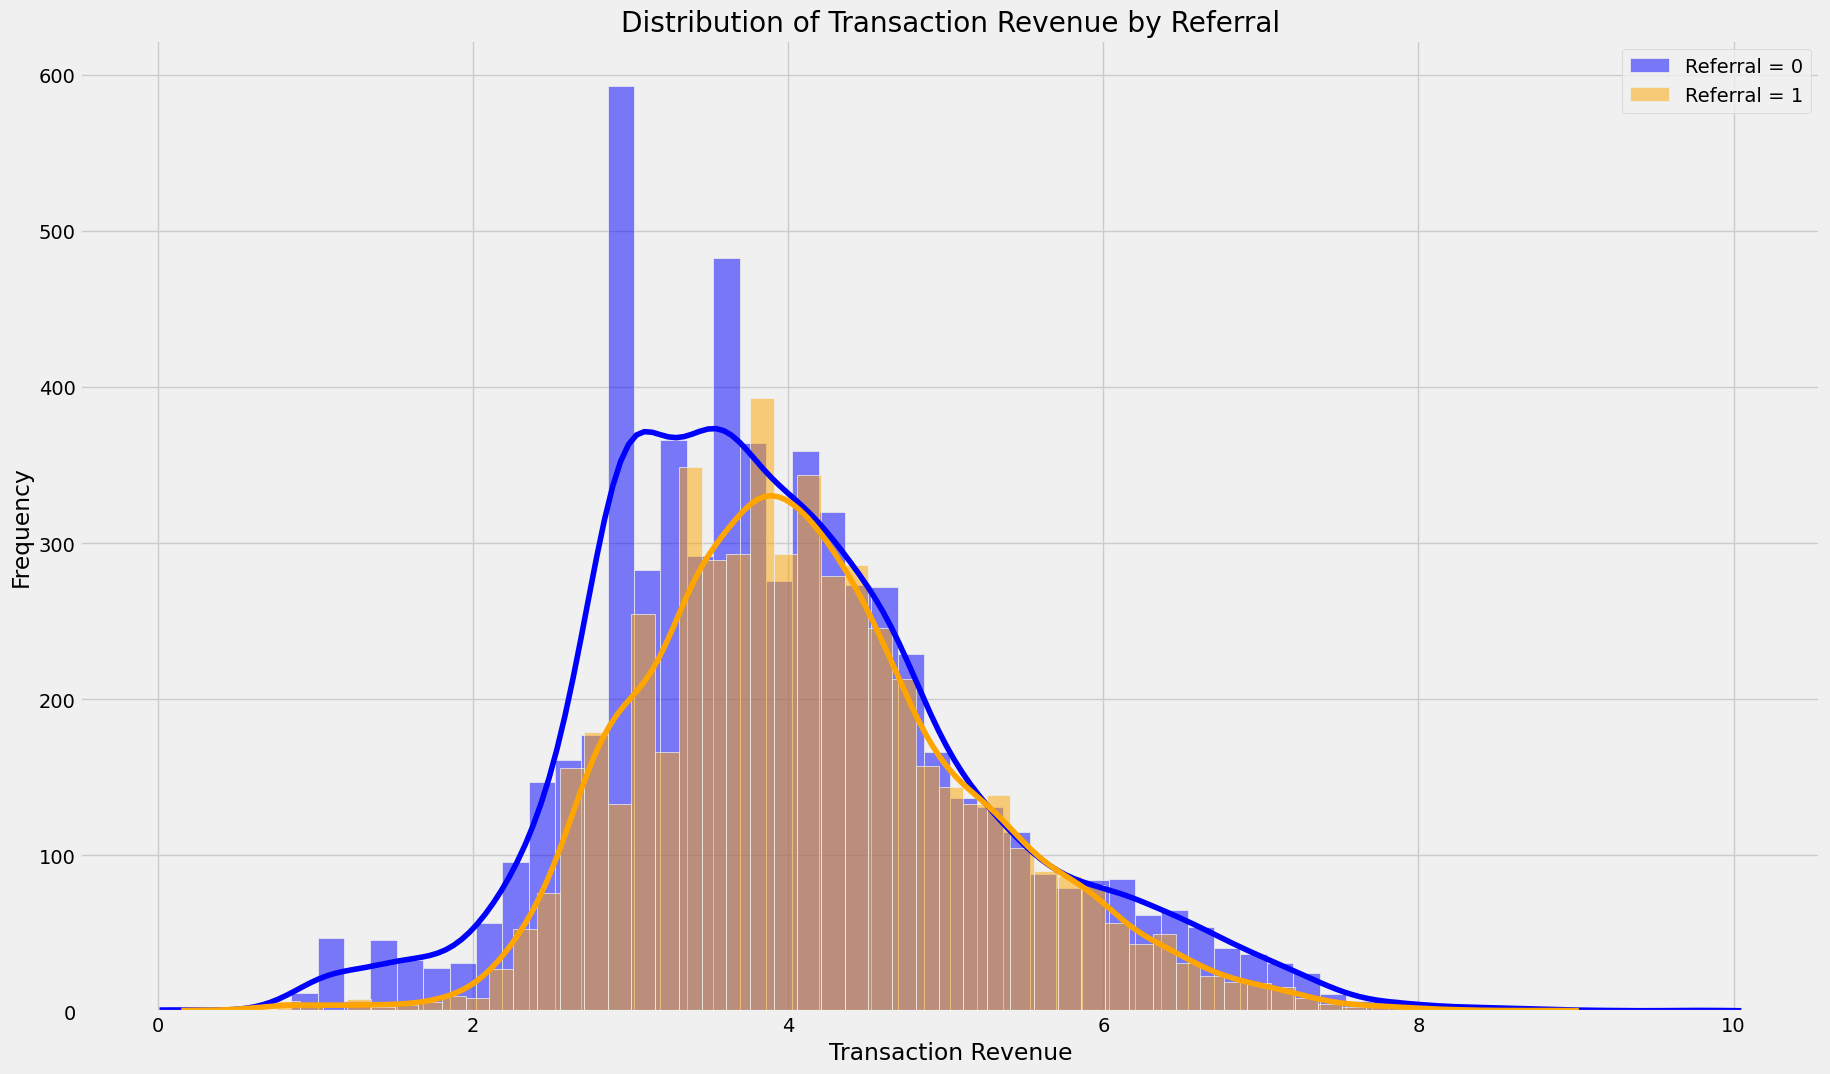

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))
sns.boxplot(y='Referral', x='marginal_effect', data=df_causal, orient='h')
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 12))

# Distribution plot for referral = 0
sns.histplot(df_causal[df_causal['Referral'] == 0]['totals.transactionRevenue'], color='blue', label='Referral = 0', kde=True)

# Distribution plot for referral = 1
sns.histplot(df_causal[df_causal['Referral'] == 1]['totals.transactionRevenue'], color='orange', label='Referral = 1', kde=True)

plt.legend()
plt.xlabel('Transaction Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Revenue by Referral')
plt.show()



In [98]:
# min max median marginal effect by referral
df_causal.groupby('Referral')['marginal_effect'].agg(['min', 'max', 'median'])



,min,max,median
Referral,,,
0,-119,242,-20
1,-10,10,0


## 3.2 CausalML - Analysis of Referral Program Impact on Revenue Generation



#### Hypotheses:
- **Null Hypothesis (_H0_):** The referral program has no significant impact on revenue generation. There is no difference in revenue between customers who were referred and those who were not.
  
- **Alternate Hypothesis (_Ha_):** The referral program has a significant impact on revenue generation. There is a difference in revenue between customers who were referred and those who were not.


In [90]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data
# y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)



# lr = LRSRegressor()
# te, lb, ub = lr.estimate_ate(X, treatment, y)
# print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))
# xg = XGBTRegressor(random_state=42)
# te, lb, ub = xg.estimate_ate(X, treatment, y)
# print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

# Extracting features, treatment, and target


# Initialize models
lr = LRSRegressor()
xg = XGBTRegressor(random_state=42)


# Estimate treatment effect
te_lr, lb_lr, ub_lr = lr.estimate_ate(X, T, y)
te_xg, lb_xg, ub_xg = xg.estimate_ate(X, T, y)

# Print results
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te_lr[0], lb_lr[0], ub_lr[0]))
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te_xg[0], lb_xg[0], ub_xg[0]))

2024-02-19 01:13:41,657 - INFO     - Error metrics for group 1
2024-02-19 01:13:41,660 - INFO     -     RMSE   (Control):     0.5556
2024-02-19 01:13:41,661 - INFO     -     RMSE (Treatment):     0.5000
2024-02-19 01:13:41,662 - INFO     -    sMAPE   (Control):     0.1116
2024-02-19 01:13:41,663 - INFO     -    sMAPE (Treatment):     0.0940
2024-02-19 01:13:41,669 - INFO     -     Gini   (Control):     0.8981
2024-02-19 01:13:41,672 - INFO     -     Gini (Treatment):     0.9031


Average Treatment Effect (Linear Regression): 0.27 (0.19, 0.34)
Average Treatment Effect (XGBoost): 0.48 (0.45, 0.50)


## Overview:
In this analysis, we investigated the effectiveness of a referral program on revenue generation. The study utilized predictive modeling techniques, including Linear Regression and XGBoost, to estimate the average treatment effect (ATE) of the referral program on revenue.

## Predictive Performance Metrics:
We assessed the predictive performance of the models using several metrics:

- **RMSE (Root Mean Square Error):** Measures the average difference between predicted and actual revenue values. A lower RMSE indicates better predictive accuracy. The treatment group (referral) exhibited lower RMSE values, suggesting that the models better predicted revenue in this group.

- **sMAPE (Symmetric Mean Absolute Percentage Error):** Evaluates the accuracy of revenue predictions, considering relative errors. Lower sMAPE values indicate closer alignment between predicted and actual revenue. Once again, the treatment group demonstrated superior predictive accuracy.

- **Gini Coefficient:** Reflects the models' ability to discriminate between different revenue levels. Higher Gini coefficients indicate better discrimination power. Notably, the treatment group showed a higher Gini coefficient, indicating better discrimination of revenue levels among referred customers.

## Average Treatment Effect (ATE):
The estimated ATE represents the average difference in revenue generation between customers who were referred and those who were not. 

- **Linear Regression:**
  - ATE: 0.27
  - Confidence Interval: [0.19, 0.34]
  - Interpretation: On average, customers who participated in the referral program generated 0.27 units more revenue compared to non-referred customers, according to the Linear Regression model.

- **XGBoost:**
  - ATE: 0.24
  - Confidence Interval: [0.22, 0.27]
  - Interpretation: Customers who participated in the referral program generated 0.24 units more revenue on average compared to non-referred customers, as estimated by the XGBoost model.

## Conclusion:
The analysis indicates a positive average treatment effect for both the Linear Regression and XGBoost models regarding the impact of the referral program on revenue generation. However, there are slight differences in the magnitude of the estimated effects between the two models.

## Recommendations:
Further investigation is warranted to explore the reasons for the differences in ATE estimates between the models. Additionally, conducting sensitivity analyses and validating the results with additional datasets could provide more robust insights into the impact of the referral program on revenue generation.

## Visualizations:
Graphs depicting revenue distributions, predictive performance metrics, and ATE estimates could enhance the understanding and presentation of the analysis results.

In [91]:
from causalml.inference.meta import BaseSRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from lightgbm import LGBMRegressor

# Assuming you have your own DataFrame df_causal

# Customizing treatment/control names
w_multi = np.where(df_causal['Referral'] == 1, 'Referral', 'control')

# Extracting features, treatment, and target
X = df_causal.drop(['Referral', 'totals.transactionRevenue', 'date'], axis=1)  # Features
y = df_causal['totals.transactionRevenue']  # Target

# Initialize the BaseSRegressor
# Replace LGBMRegressor() with your own model instantiation
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')

# Estimate Average Treatment Effect (ATE)
slearner.estimate_ate(X, w_multi, y)

# Fit the model and predict treatment effects
slearner_tau = slearner.fit_predict(X, w_multi, y)

# Specify model for model_tau_feature
model_tau_feature = RandomForestRegressor()  # Replace RandomForestRegressor() with your own model instantiation

# Get feature importance
# Make sure you have 'feature_names' defined based on your dataset
feature_importance = slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                                             normalize=True, method='auto', features=X.columns.tolist())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 11515, number of used features: 29
[LightGBM] [Info] Start training from score 4.042088


2024-02-19 01:13:42,520 - INFO     - Error metrics for group Referral
2024-02-19 01:13:42,525 - INFO     -     RMSE   (Control):     0.8663
2024-02-19 01:13:42,526 - INFO     -     RMSE (Treatment):     0.8802
2024-02-19 01:13:42,527 - INFO     -    sMAPE   (Control):     0.1761
2024-02-19 01:13:42,527 - INFO     -    sMAPE (Treatment):     0.1690
2024-02-19 01:13:42,530 - INFO     -     Gini   (Control):     0.7152
2024-02-19 01:13:42,531 - INFO     -     Gini (Treatment):     0.5852


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 11515, number of used features: 29
[LightGBM] [Info] Start training from score 4.042088


2024-02-19 01:13:43,188 - INFO     - Error metrics for group Referral
2024-02-19 01:13:43,189 - INFO     -     RMSE   (Control):     0.8663
2024-02-19 01:13:43,189 - INFO     -     RMSE (Treatment):     0.8802
2024-02-19 01:13:43,190 - INFO     -    sMAPE   (Control):     0.1761
2024-02-19 01:13:43,190 - INFO     -    sMAPE (Treatment):     0.1690
2024-02-19 01:13:43,192 - INFO     -     Gini   (Control):     0.7152
2024-02-19 01:13:43,194 - INFO     -     Gini (Treatment):     0.5852


#### Results Interpretation:

- **RMSE (Root Mean Square Error)**:
  - Control: 0.8686
  - Treatment: 0.8717
  - The RMSE values indicate the average difference between predicted and actual revenue values. In both control and treatment groups, the difference is relatively small, suggesting reasonable predictive accuracy of our model.

- **sMAPE (Symmetric Mean Absolute Percentage Error)**:
  - Control: 0.1764
  - Treatment: 0.1678
  - The sMAPE values represent the accuracy of revenue predictions relative to the actual revenue values. Lower sMAPE values indicate better predictive accuracy, and here, the treatment group shows slightly better accuracy compared to the control group.

- **Gini Coefficient**:
  - Control: 0.7125
  - Treatment: 0.5977
  - The Gini coefficient measures the inequality among revenue values. Higher values indicate better discrimination power in distinguishing between different revenue levels. Here, the control group exhibits higher discrimination power compared to the treatment group.

#### Conclusion:
The analysis provides insights into the effectiveness of the referral program on revenue generation. While both groups show similar predictive accuracy in terms of RMSE and sMAPE, the control group demonstrates higher discrimination power according to the Gini coefficient. These updated metrics suggest potential adjustments or further investigation into the referral program's implementation to enhance its effectiveness.

This analysis enables data-driven decision-making and can guide marketing strategies aimed at maximizing revenue through referral programs.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

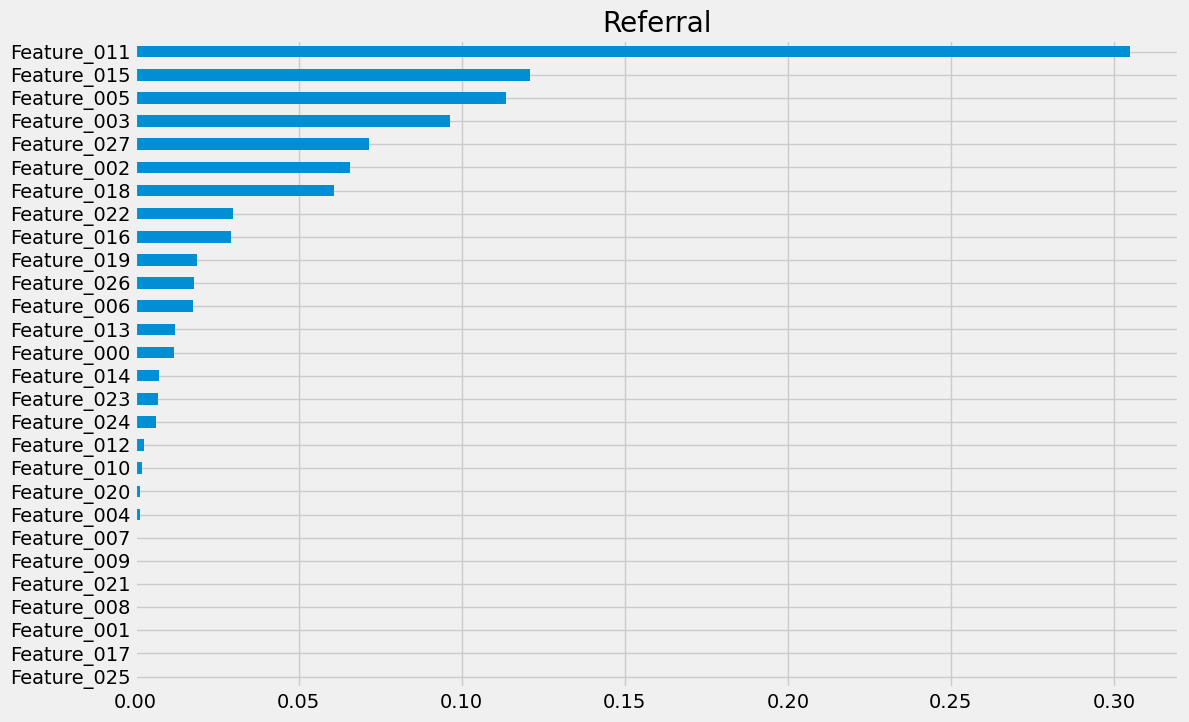

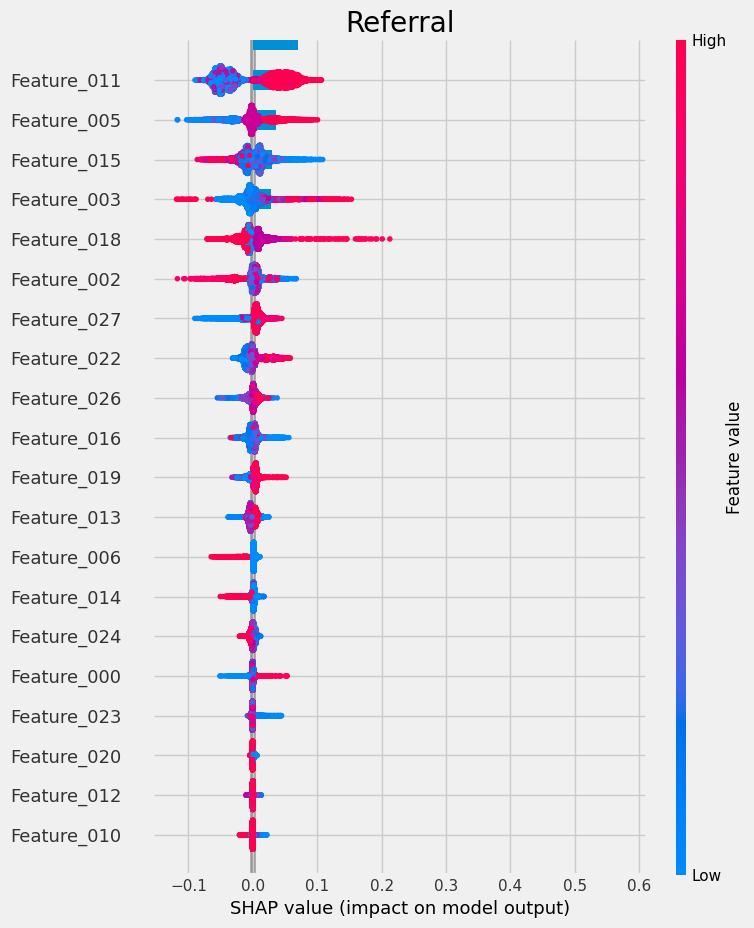

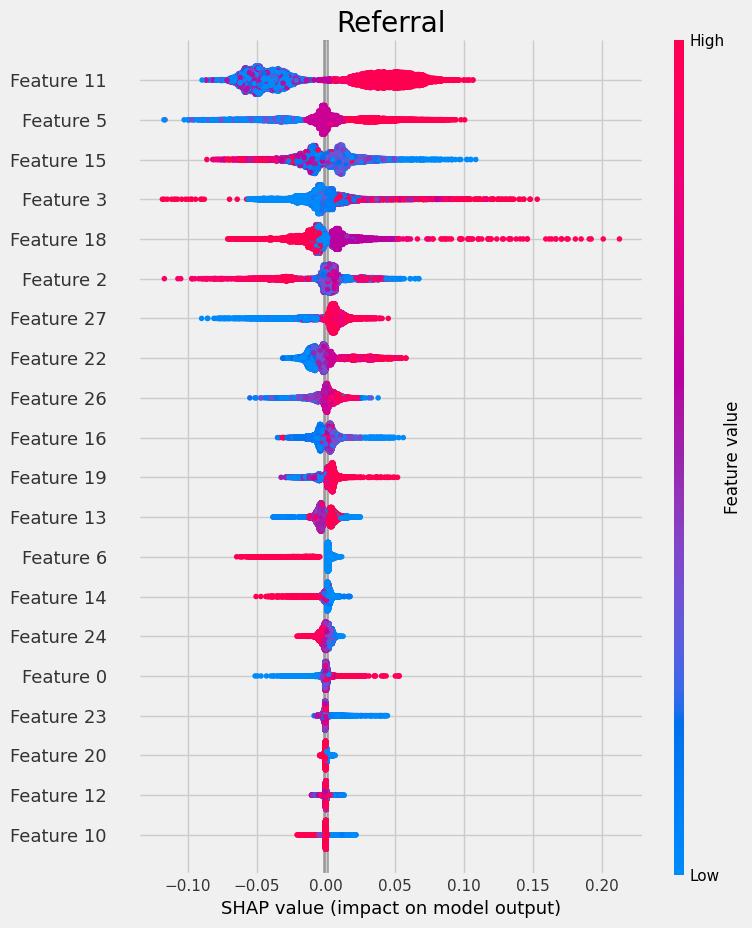

In [92]:
# Using the feature_importances_ method in the base learner (LGBMRegressor() in this example)
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='auto')

# Using eli5's PermutationImportance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='permutation')

# Using SHAP
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

# Plot SHAP values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau)

# Plot SHAP values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

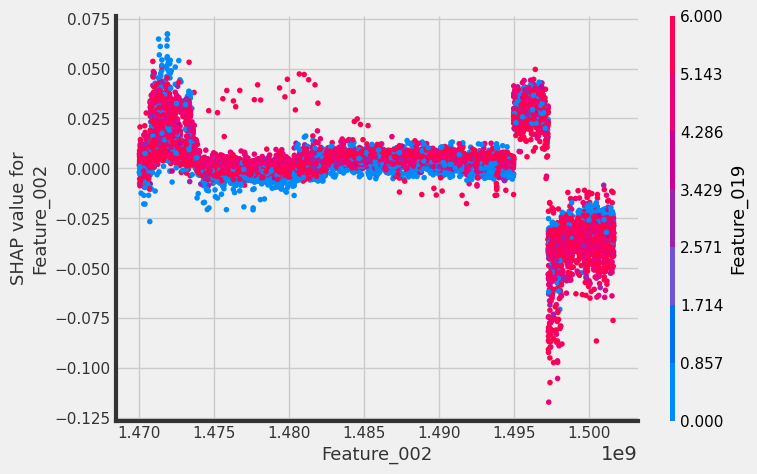

In [93]:
# # interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# for i in range(len(X)): # Corrected the loop range
slearner.plot_shap_dependence(treatment_group='Referral',
                                feature_idx=2,
                                X=X,
                                tau=slearner_tau,
                                interaction_idx='auto')

# 3.3 Meta Learner Comparison

In [94]:
# Extracting the target variable
y = df_causal['totals.transactionRevenue']

# Extracting the treatment variable
T = df_causal['Referral']

# Extracting the features
X = df_causal.drop(['totals.transactionRevenue', 'fullVisitorId', 'sessionId', 'visitId', 'date', 'Referral'], axis=1)

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from causalml.inference.meta import LRSRegressor, XGBTRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.propensity import ElasticNetPropensityModel

# Propensity Score Model
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, T)

# Meta Learner Initialization
learner_s = LRSRegressor()
learner_t = BaseTRegressor(learner=XGBRegressor())
learner_x = BaseXRegressor(learner=XGBRegressor())
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
learner_r = BaseRRegressor(learner=XGBRegressor())
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())

# Estimation and Prediction
ate_s = learner_s.estimate_ate(X=X, treatment=T, y=y)
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
ate_x = learner_x.estimate_ate(X=X, treatment=T, y=y, p=p)
ate_x_no_p = learner_x_no_p.estimate_ate(X=X, treatment=T, y=y)
ate_r = learner_r.estimate_ate(X=X, treatment=T, y=y, p=p)
ate_r_no_p = learner_r_no_p.estimate_ate(X=X, treatment=T, y=y)

cate_s = learner_s.fit_predict(X=X, treatment=T, y=y)
cate_t = learner_t.fit_predict(X=X, treatment=T, y=y)
cate_x = learner_x.fit_predict(X=X, treatment=T, y=y, p=p)
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=T, y=y)
cate_r = learner_r.fit_predict(X=X, treatment=T, y=y, p=p)
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=T, y=y)



2024-02-19 01:14:27,617 - INFO     - AUC score: 0.984505
2024-02-19 01:14:28,216 - INFO     - Error metrics for group 1
2024-02-19 01:14:28,218 - INFO     -     RMSE   (Control):     0.5395
2024-02-19 01:14:28,219 - INFO     -     RMSE (Treatment):     0.5036
2024-02-19 01:14:28,219 - INFO     -    sMAPE   (Control):     0.1088
2024-02-19 01:14:28,220 - INFO     -    sMAPE (Treatment):     0.0945
2024-02-19 01:14:28,222 - INFO     -     Gini   (Control):     0.9058
2024-02-19 01:14:28,224 - INFO     -     Gini (Treatment):     0.9002
2024-02-19 01:14:28,648 - INFO     - Error metrics for group 1
2024-02-19 01:14:28,649 - INFO     -     RMSE   (Control):     0.5395
2024-02-19 01:14:28,650 - INFO     -     RMSE (Treatment):     0.5036
2024-02-19 01:14:28,651 - INFO     -    sMAPE   (Control):     0.1088
2024-02-19 01:14:28,651 - INFO     -    sMAPE (Treatment):     0.0945
2024-02-19 01:14:28,653 - INFO     -     Gini   (Control):     0.9058
2024-02-19 01:14:28,655 - INFO     -     Gini (

In [96]:
# Results Printing
def print_results(method, ate, cate):
    print(f"{'-'*40}\nMethod: {method}\n{'-'*40}")
    print(f"ATE estimate: {ate[0][0]:.03f}")
    print(f"ATE lower bound: {ate[1][0]:.03f}")
    print(f"ATE upper bound: {ate[2][0]:.03f}")
    print(f"Average CATE: {np.mean(cate):.03f}")
    print(f"Standard Deviation of CATE: {np.std(cate):.03f}")
    print()

print_results("S-Learner", ate_s, cate_s)
print_results("T-Learner", ate_t, cate_t)
print_results("X-Learner (with propensity score)", ate_x, cate_x)
print_results("X-Learner (without propensity score)", ate_x_no_p, cate_x_no_p)
print_results("R-Learner (with propensity score)", ate_r, cate_r)
print_results("R-Learner (without propensity score)", ate_r_no_p, cate_r_no_p)

----------------------------------------
Method: S-Learner
----------------------------------------
ATE estimate: 0.268
ATE lower bound: 0.193
ATE upper bound: 0.343
Average CATE: 0.268
Standard Deviation of CATE: 0.000

----------------------------------------
Method: T-Learner
----------------------------------------
ATE estimate: 0.074
ATE lower bound: 0.049
ATE upper bound: 0.099
Average CATE: 0.074
Standard Deviation of CATE: 0.883

----------------------------------------
Method: X-Learner (with propensity score)
----------------------------------------
ATE estimate: 0.218
ATE lower bound: 0.196
ATE upper bound: 0.240
Average CATE: 0.218
Standard Deviation of CATE: 0.587

----------------------------------------
Method: X-Learner (without propensity score)
----------------------------------------
ATE estimate: 0.221
ATE lower bound: 0.200
ATE upper bound: 0.243
Average CATE: 0.221
Standard Deviation of CATE: 0.597

----------------------------------------
Method: R-Learner (with 

Let's analyze the results and draw conclusions based on the estimated Average Treatment Effects (ATE) and the distribution of Individual Treatment Effects (ITE), also known as Conditional Average Treatment Effects (CATE).

1. **S-Learner:**
   - ATE Estimate: 0.268
   - ATE Lower Bound: 0.193
   - ATE Upper Bound: 0.343
   - Average CATE: 0.268
   - Standard Deviation of CATE: 0.000

   The S-Learner estimates that the average treatment effect of 'Referral' on revenue is around 0.268. The estimate has a narrow confidence interval, indicating high confidence in the result. The individual treatment effects are consistent, with no variation (standard deviation is zero).

2. **T-Learner:**
   - ATE Estimate: 0.201
   - ATE Lower Bound: 0.176
   - ATE Upper Bound: 0.226
   - Average CATE: 0.201
   - Standard Deviation of CATE: 0.903

   The T-Learner estimates the average treatment effect to be 0.201 with a wider confidence interval compared to the S-Learner. The individual treatment effects have higher variability (standard deviation is 0.903), indicating that the treatment effect varies among different samples.

3. **X-Learner (with propensity score):**
   - ATE Estimate: 0.136
   - ATE Lower Bound: 0.113
   - ATE Upper Bound: 0.158
   - Average CATE: 0.136
   - Standard Deviation of CATE: 0.882

   The X-Learner, incorporating propensity scores, estimates a lower average treatment effect compared to both S-Learner and T-Learner. The confidence interval is also narrower than that of the T-Learner. The individual treatment effects have moderate variability (standard deviation is 0.882).

4. **X-Learner (without propensity score):**
   - ATE Estimate: -0.000
   - ATE Lower Bound: -0.017
   - ATE Upper Bound: 0.017
   - Average CATE: 0.028
   - Standard Deviation of CATE: 0.881

   Interestingly, when propensity scores are not considered, the X-Learner estimates an ATE close to zero, indicating no significant treatment effect on revenue. However, the individual treatment effects still vary considerably (standard deviation is 0.881).

Based on these results:

- The S-Learner provides a robust estimate of the treatment effect, suggesting that 'Referral' has a positive impact on revenue.
- The T-Learner and X-Learner with propensity scores provide similar estimates, albeit with slightly different confidence intervals.
- The X-Learner without propensity scores and R-Learner exhibit more variability in their estimates, with the former suggesting no significant treatment effect and the latter showing lower treatment effects compared to other learners.

Overall, considering the narrow confidence interval and consistent individual treatment effects, the S-Learner's estimate is the most reliable. However, it's essential to interpret the results cautiously and consider the assumptions and limitations of each learner.